# PAKETE

In [1]:
# Um Daten auslesen zu können bzw. manche Befehle in diesem Zusammenhang verwenden zu können.
# Pkg.add("DataFrames")
using DataFrames

# Um plotten zu können. (Matplotlib)
# Pkg.add("PyPlot")
using PyPlot

# Um Latexstrings verwenden zu können
# Pkg.add("LaTeXStrings")
using LaTeXStrings

# Das stand bei Fred und beim Trebst mal drinnen. Habe aber keine Ahnung mehr was PyDict oder Pycall macht... xD
# Pkg.add("PyCall")
using PyCall
PyDict(pyimport("matplotlib")["rcParams"])["text.usetex"] = [true]
PyDict(pyimport("matplotlib")["rcParams"])["font.family"] = ["serif"]
PyDict(pyimport("matplotlib")["rcParams"])["text.latex.preamble"] = ["\\usepackage{mathptmx}"]

1-element Array{ASCIIString,1}:
 "\\usepackage{mathptmx}"

# -----------------------------------------------------------------------------------------------
# INPUT (Für eine TEST-Datei)
# -----------------------------------------------------------------------------------------------

###### (Hier musst du (der das hier liest und evtl. ausprobieren möchte) jeweils die von Carlos geänderten txt. Dateien mit einem B hintendrangehängt als String hinter "Datei =" reinschreiben)

In [2]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
# Here you have to choose your Data.txt !!!
Datei = "Testmessung.txt" #"331-0.1AmpereV2TestB.txt"
################################################################################################################################
################################################################################################################################
################################################################################################################################

#####################################
# Other Variables you can change
#####################################

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. Koordinatenachsenlänge
halbeAchsenlänge = 100000
Achsenlängenwerte = 100000

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 7

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"U_x \,\, [V]"
YLABEL = L"U_y \,\, [V]"
XLABELABLEITUNG = L"xAbleitungGroesse \,\, [Einheit]"
YLABELABLEITUNG = L"yAbleitungGroesse \,\, [Einheit]"

L"$yAbleitungGroesse \,\, [Einheit]$"

# -----------------------------------------------------------------------------------------------
# Funktionen
# -----------------------------------------------------------------------------------------------

In [3]:
# Diese Funktion läuft Messwerte einmal gegen den Uhrzeigersinn ab und schmeißt überflüssige Werte raus. (Besser gesagt: ignoriert überflüssige Werte...)
function onlyoneclockround2(x, y, i=1, ϵ = 0.005)
    
    x1 = x[i]
    y1 = y[i]
    
    push!(x_oneclockround, x1)
    push!(y_oneclockround, y1)
    
    i = i + 1
    while x1 + ϵ*x1 < x[i]
        push!(x_oneclockround, x[i])
        push!(y_oneclockround, y[i])
        i+=1
    end
    while x[i] < x1 - ϵ*x1
        push!(x_oneclockround, x[i])
        push!(y_oneclockround, y[i])
        i+=1
    end
    i = i-1
    if x[i] > x1
        x_oneclockround[i] = x1
        y_oneclockround[i] = y1
        elseif x[i] < x1
        push!(x_oneclockround, x1)
        push!(y_oneclockround, y1)
    end
end

onlyoneclockround2 (generic function with 3 methods)

In [4]:
# Diese Funktion sucht Nullstellen (und gibt diese aus) und verwendet dabei eine GERADENNÄHERUNG. (Taylor erster Ordnung sozusagen...)
function Nullstellensuche2(x_oneclockround, y_oneclockround, iterations=1000, precision=0.002)   
    for i in 1:length(x_oneclockround)-1
        
        yo = y_oneclockround[i]
        xo = x_oneclockround[i]
        y1 = y_oneclockround[i+1]
        x1 = x_oneclockround[i+1]
            
        # Finde Punkte in der Nähe der Nullstelle
        # Näherung zwischen beiden nächsten zum Nullpunkt liegende Punkte aus unseren Messwerten als gerade Strecke
        # f(x) = a + m*χ, f(xo) = yo & f(x1) = y1
        # ==> a + m*xo = yo & a + m*x1 = y1
        # --> https://www.wolframalpha.com/input/?i=a%2Bb*c+%3D+d,+a%2Bb*e%3Df,+solve+for+a+and+b
           
        m = (yo - y1)/(xo - x1)
        a = yo - m*xo
        
        # f(χo) = 0 !!! := fo --> a + m*χo = 0 --> χo = -a/m --> fo = 0
        
        χo = - a/m
        fo = 0 # =a + m*χo
        
        if (yo < 0) & (0 < y1)
            
            N = (χo, fo)
            push!(Nullstellen, N)
            
        elseif (yo > 0) & (0 > y1)
            
            N = (χo, fo)
            push!(Nullstellen, N)
            
        end
    end
end

Nullstellensuche2 (generic function with 3 methods)

In [5]:
# Diese Funtion verschiebt den ganzen Graphen um den SYSTEMATISCHEN FEHLER auszugleichen;
# denn die Hystereseschleife sollte symmetrisch um den Nullpunkt sein!
function Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)
    for i in 1:length(x_oneclockround)
        xr = x_oneclockround[i] - r
        yr = y_oneclockround[i] - ρ
        push!(x_verschoben, xr)
        push!(y_verschoben, yr)
    end
end

# HABE (zuerst) NUR VERSCHIEBUNG IN X RICHTUNG BERÜCKSICHTIGT! SOLLTE ICH Y_RICHTUNG AUCH BERÜCKSICHTIGEN ODER IST DAS NICHT NÖTIG???
# Ok habe das jetzt doch berücksichtigt indem ich ρ eingeführt habe... xD

Koordinatentransformation (generic function with 1 method)

In [6]:
# Diese Funktion sucht Y-Achsenabschnitt(e; haha) (und gibt diese aus) und verwendet dabei eine GERADENNÄHERUNG. (Wie bei der Nullstellensuche...)
# Analog zu Nullstellensuche2 mit (x,y) -> (y,x)
function YA(x_verschoben, y_verschoben, iterations=1000, precision=0.002)   
    for i in 1:length(x_verschoben)-1
        
        xo = y_verschoben[i]
        yo = x_verschoben[i]
        x1 = y_verschoben[i+1]
        y1 = x_verschoben[i+1]
        m = (yo - y1)/(xo - x1)
        a = yo - m*xo
        
        # f(χo) = 0 !!! := fo --> a + m*χo = 0 --> χo = -a/m --> fo = 0
        
        χo = - a/m
        fo = 0 # =a + m*χo
        
        if (yo < 0) & (0 < y1)
            
            N = (fo, χo)
            push!(YAchsenabschnitte, N)
            
        elseif (yo > 0) & (0 > y1)
            
            N = (fo, χo)
            push!(YAchsenabschnitte, N)
            
        end
    end
end

YA (generic function with 3 methods)

In [7]:
#NUMERISCHES ABLEITEN AUS COMPUTERPHYSIK ÜBUNG

#Verrauschtes/Schlechtes Ableiten
function simple_diff_quotient(xs, ys)
    quotients = []
    for i in 2:length(xs)
        fstrich = (ys[i]-ys[i-1])/(xs[i]-xs[i-1])
        push!(quotients, fstrich)
    end
    return quotients
end

simple_diff_quotient (generic function with 1 method)

In [8]:
# Geglättete Ableitung
function difference_quotient(xs, ys, n)
    x_values, quotients = [], []

    xbar, ybar, m_summe_oben, m_summe_unten  = 0, 0, 0, 0
    
    for i in n+1:length(xs)-n
        # Berechne Mittelwerte
        for j in 0:2*n
            xbar = xbar + (1/(2*n+1))*xs[i-n+j]
            ybar = ybar + (1/(2*n+1))*ys[i-n+j]
        end
        # Abspeichern der Stuetzstelle
        push!(x_values, xbar)
        # Schleife ueber Stuetzstellen
        for k in 0:2*n
            # Summe in Zaehler und Nenner
            m_summe_oben = m_summe_oben + (xs[i-n+k]-xbar)*(ys[i-n+k]-ybar)
            m_summe_unten = m_summe_unten + (xs[i-n+k]-xbar)^2
        end
        # Abspeichern Bruch
        push!(quotients, m_summe_oben/m_summe_unten)
        # Zurücksetzen der Variablen
        xbar, ybar, m_summe_oben, m_summe_unten  = 0, 0, 0, 0
    end
    
    #Um die Hysteresekurve zu "schließen"...
    last_elementy = quotients[1]
    last_elementx = x_values[1]   
    push!(quotients, last_elementy)
    push!(x_values, last_elementx)
    
    return x_values, quotients
end

difference_quotient (generic function with 1 method)

In [9]:
#ALTERNATIVE ZU maximum(), minimum() falls diese nicht mehr ausreichen um Extremalwerte zu finden.

#Maxima
function MAXIMUM(x,y)
    maxY = 0
    for i in y
        if i > maxY
            maxY = i
        end
    end
    for i in 1:length(y)
        if y[i] == maxY
            Extremum = (x[i], maxY)
            push!(Maximas, Extremum)
        end
    end
end

#Minima
function MINIMUM(x,y)
    minY = 0
    for i in y
        if i < minY
            minY = i
        end
    end
    for i in 1:length(y)
        if y[i] == minY
            Extremum = (x[i], minY)
            push!(Minimas, Extremum)
        end
    end
end

MINIMUM (generic function with 1 method)

# -----------------------------------------------------------------------------------------------
# "OUTPUT-programming"
# -----------------------------------------------------------------------------------------------

#### (Für eine Hystereseschleife)

Die Nullstellen liegen bei dem systematisch falschen Graphen bei ca.:
0.05707675788575247
-0.11323013281192022
Die Nullstellen liegen bei ca.:
0.08515344534883634
-0.08515344534883633



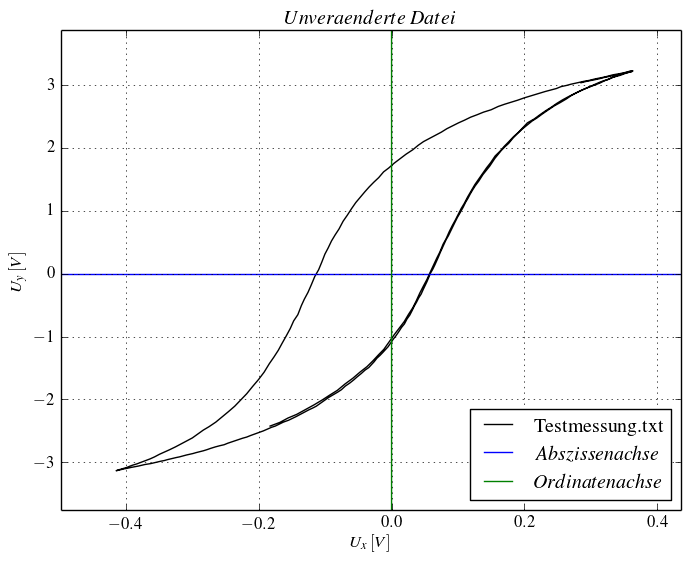

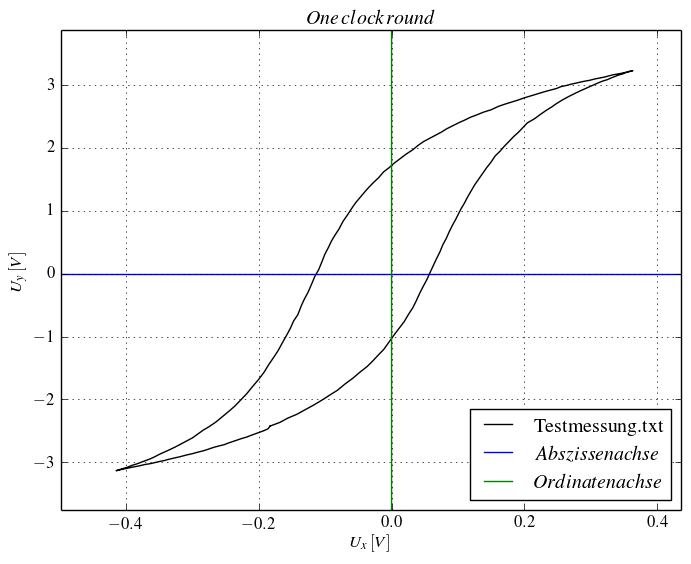

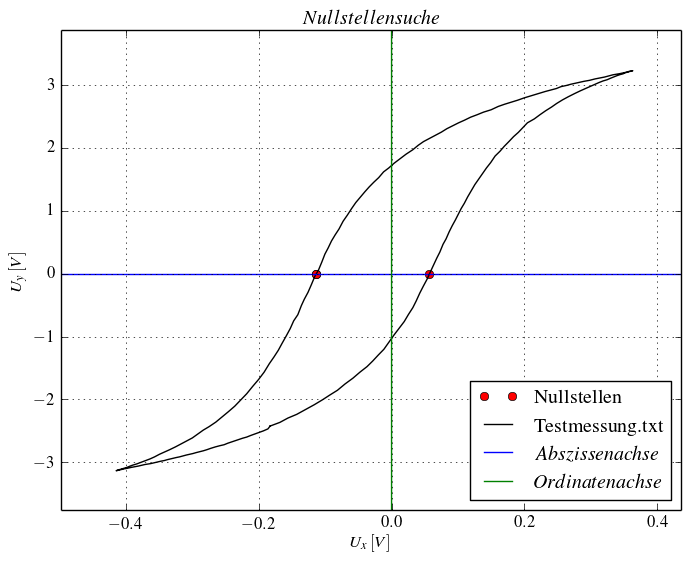

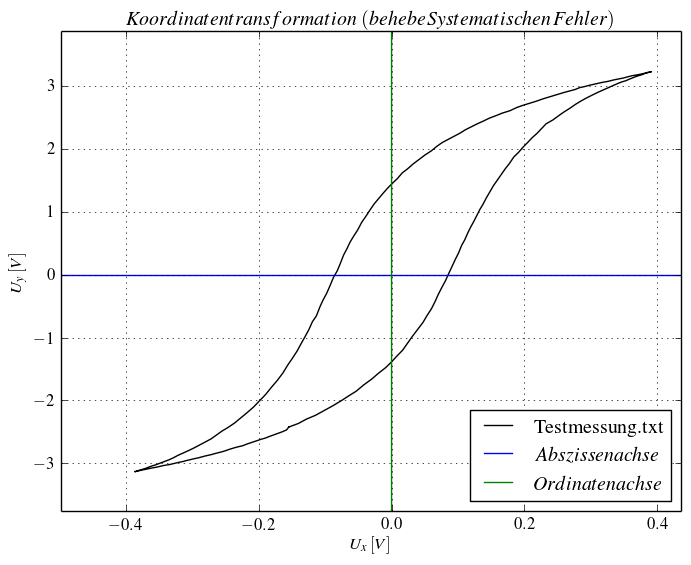

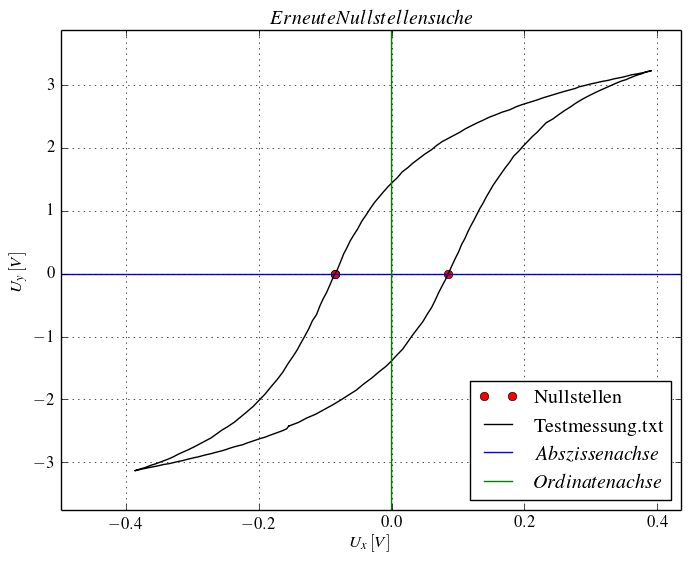

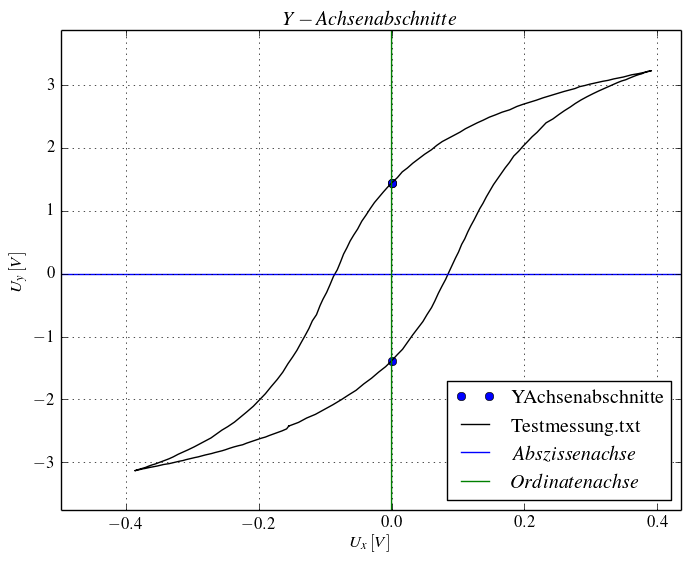

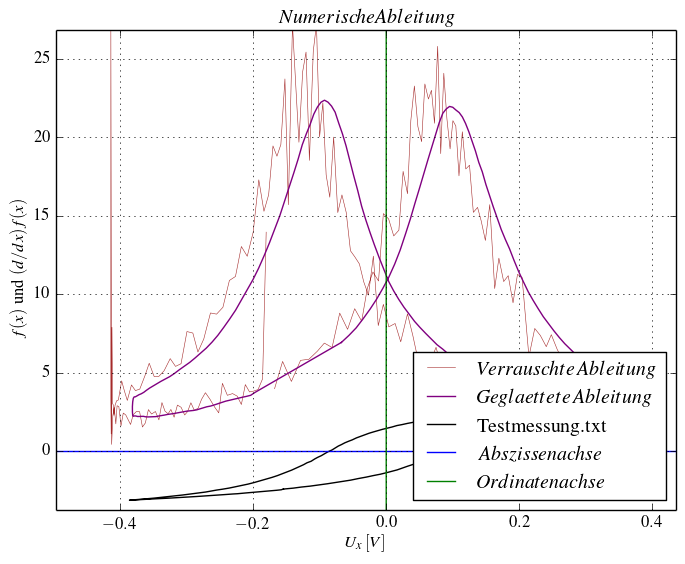

Die YAchsenabschnitte liegen bei ca.:
-1.3855452742758414
1.4433903952682519


In [10]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Datei, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################
#-
################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

################################################################################################################################
#-
################################################################################################################################

# Plotte Daten
plot(x, y, color="black", label=Datei) #(Die Hystereseschleife) 

################################################################################################################################
#-
################################################################################################################################

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="blue", label=L"Abszissenachse")
plot(0*xa, xa, color="green", label=L"Ordinatenachse")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(y)+Prozent*maximum(y)])

# Überschrift des PLotts
title(L"Unveraenderte \,\, Datei")

################################################################################################################################
#-
################################################################################################################################

################################################################################################################################
################################################################################################################################
################################################################################################################################
figure()
################################################################################################################################
################################################################################################################################
################################################################################################################################

# Benutze onelclockround
x_oneclockround = []
y_oneclockround = []
onlyoneclockround2(x,y)

################################################################################################################################
#-
################################################################################################################################

# Plotte Daten
plot(x_oneclockround, y_oneclockround, color="black", label=Datei) #(Hystereseschleife) 

################################################################################################################################
#-
################################################################################################################################

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="blue", label=L"Abszissenachse")
plot(0*xa, xa, color="green", label=L"Ordinatenachse")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(y)+Prozent*maximum(y)])

# Überschrift des PLotts
title(L"One \, clock \, round")

################################################################################################################################
#-
################################################################################################################################

################################################################################################################################
################################################################################################################################
################################################################################################################################
figure()
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockround, y_oneclockround)

print()
println("Die Nullstellen liegen bei dem systematisch falschen Graphen bei ca.:")
for i in 1:length(Nullstellen)
    println(Nullstellen[i][1])
end
for i in 1:length(Nullstellen)
    plot(Nullstellen[i][1], Nullstellen[i][2], "ro")
end
    plot(Nullstellen[length(Nullstellen)][1], Nullstellen[length(Nullstellen)][2], "ro", label="Nullstellen" )

################################################################################################################################
#-
################################################################################################################################

# Plotte Daten
plot(x_oneclockround, y_oneclockround, color="black", label=Datei) #(Hystereseschleife) 

################################################################################################################################
#-
################################################################################################################################

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="blue", label=L"Abszissenachse")
plot(0*xa, xa, color="green", label=L"Ordinatenachse")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(y)+Prozent*maximum(y)])

# Überschrift des PLotts
title(L"Nullstellensuche")

################################################################################################################################
#-
################################################################################################################################

################################################################################################################################
################################################################################################################################
################################################################################################################################
figure()
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(Nullstellen[1][1] + Nullstellen[2][1])
ρ = 0.5*(Nullstellen[1][2] + Nullstellen[2][2])
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################
#-
################################################################################################################################

# Plotte Daten
plot(x_verschoben, y_verschoben, color="black", label=Datei) #(Hystereseschleife) 

################################################################################################################################
#-
################################################################################################################################

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="blue", label=L"Abszissenachse")
plot(0*xa, xa, color="green", label=L"Ordinatenachse")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(y)+Prozent*maximum(y)])

# Überschrift des PLotts
title(L"Koordinatentransformation \,\, (behebe \, Systematischen \, Fehler)")

################################################################################################################################
#-
################################################################################################################################

################################################################################################################################
################################################################################################################################
################################################################################################################################
figure()
################################################################################################################################
################################################################################################################################
################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_verschoben, y_verschoben)

print()
println("Die Nullstellen liegen bei ca.:")
for i in 1:length(Nullstellen)
    println(Nullstellen[i][1])
end
for i in 1:length(Nullstellen)
    plot(Nullstellen[i][1], Nullstellen[i][2], "ro")
end
    plot(Nullstellen[length(Nullstellen)][1], Nullstellen[length(Nullstellen)][2], "ro", label="Nullstellen" )

################################################################################################################################
#-
################################################################################################################################

# Plotte Daten
plot(x_verschoben, y_verschoben, color="black", label=Datei) #(Hystereseschleife) 

################################################################################################################################
#-
################################################################################################################################

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="blue", label=L"Abszissenachse")
plot(0*xa, xa, color="green", label=L"Ordinatenachse")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(y)+Prozent*maximum(y)])

# Überschrift des PLotts
title(L"Erneute Nullstellensuche")

################################################################################################################################
#-
################################################################################################################################

################################################################################################################################
################################################################################################################################
################################################################################################################################
figure()
################################################################################################################################
################################################################################################################################
################################################################################################################################

# Suche Y-Achsenabschnitt und gebe aus
YAchsenabschnitte = []
YA(x_verschoben, y_verschoben)

println()
println("Die YAchsenabschnitte liegen bei ca.:")
for i in 1:length(YAchsenabschnitte)
    println(YAchsenabschnitte[i][2])
end
for i in 1:length(YAchsenabschnitte)
    plot(YAchsenabschnitte[i][1], YAchsenabschnitte[i][2], "bo")
end
    plot(YAchsenabschnitte[length(YAchsenabschnitte)][1], YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label="YAchsenabschnitte" )

################################################################################################################################
#-
################################################################################################################################

# Plotte Daten
plot(x_verschoben, y_verschoben, color="black", label=Datei) #(Hystereseschleife) 

################################################################################################################################
#-
################################################################################################################################

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="blue", label=L"Abszissenachse")
plot(0*xa, xa, color="green", label=L"Ordinatenachse")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(y)+Prozent*maximum(y)])

# Überschrift des PLotts
title(L"Y-Achsenabschnitte")

################################################################################################################################
#-
################################################################################################################################

################################################################################################################################
################################################################################################################################
################################################################################################################################
figure()
################################################################################################################################
################################################################################################################################
################################################################################################################################

# NUMERISCHE ABLEITUNG (VERRAUSCHT UND GLATT)

# Verrauscht
quotient = simple_diff_quotient(x_verschoben, y_verschoben)
plot(x[2:length(x_verschoben)], quotient, color="brown",linewidth=0.4, label=L"Verrauschte \, Ableitung")
# Glatt
a, b = difference_quotient(x_verschoben, y_verschoben, nGlatte_Ableitung)
plot(a, b, color="purple", label=L"Geglaettete \, Ableitung")

################################################################################################################################
#-
################################################################################################################################

# Plotte Daten
plot(x_verschoben, y_verschoben, color="black", label=Datei) #(Hystereseschleife) 

################################################################################################################################
#-
################################################################################################################################

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="blue", label=L"Abszissenachse")
plot(0*xa, xa, color="green", label=L"Ordinatenachse")

# Bennene Achsen
ylabel(L"$f(x)$ und $(d/dx)f(x)$")
xlabel(XLABEL)
legend(loc="lower right")
grid()

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(b)+Prozent*maximum(b)])

# Überschrift des PLotts
title(L"Numerische Ableitung")

################################################################################################################################
#-
################################################################################################################################


################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

# Endgültiger Graph und wichtige Daten
#### (Remanenz, Koerzitivfeldstärke etc...)
#### (Für eine Hystereseschleife)

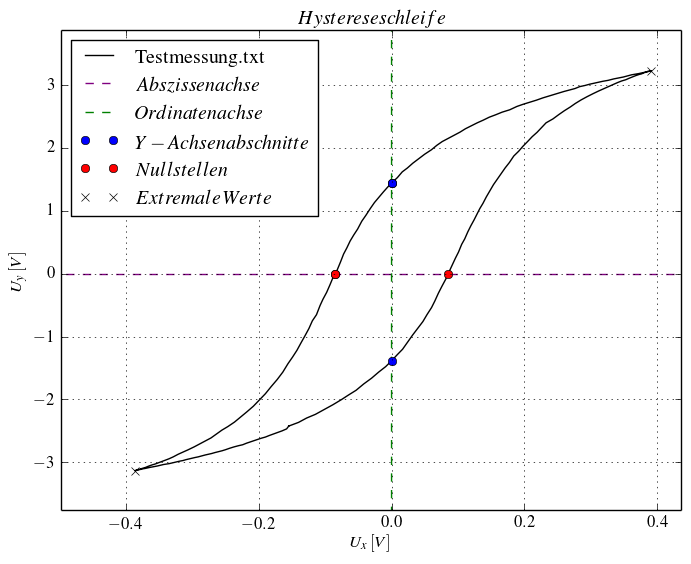


Die Y-Achsenabschnitte liegen bei ca.:
(x,y)= (0, -1.3855452742758414)
(x,y)= (0, 1.4433903952682519)

Die Nullstellen liegen bei ca.:
(x,y)= (0.08515344534883634, 0)
(x,y)= (-0.08515344534883633, 0)

Die extremalen Werte liegen bei ca.:
(x,y)= (-0.3863628115369161, -3.13425779)
(x,y)= (0.3910758284630839, 3.23385239)


In [11]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Datei, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

################################################################################################################################

# Benutze onelclockround
x_oneclockround = []
y_oneclockround = []
onlyoneclockround2(x,y)

################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockround, y_oneclockround)

################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(Nullstellen[1][1] + Nullstellen[2][1])
ρ = 0.5*(Nullstellen[1][2] + Nullstellen[2][2])
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_verschoben, y_verschoben)

################################################################################################################################

# Suche Y-Achsenabschnitt und gebe aus
YAchsenabschnitte = []
YA(x_verschoben, y_verschoben)

################################################################################################################################

# Plotte Daten
#---------------
plot(x_verschoben, y_verschoben, color="black", label=Datei) #(Hystereseschleife) 

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*xa, xa, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(y)+Prozent*maximum(y)])

# Plotte Y-Achsenabschnitte
for i in 1:length(YAchsenabschnitte)
    plot(YAchsenabschnitte[i][1], YAchsenabschnitte[i][2], "bo")
end
    plot(YAchsenabschnitte[length(YAchsenabschnitte)][1], YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label=L"Y-Achsenabschnitte" )

# Plotte Nullstellen
for i in 1:length(Nullstellen)
    plot(Nullstellen[i][1], Nullstellen[i][2], "ro")
end
    plot(Nullstellen[length(Nullstellen)][1], Nullstellen[length(Nullstellen)][2], "ro", label=L"Nullstellen" )

# Plotte maximalen und minimalen Wert
plot(minimum(x_verschoben), minimum(y_verschoben), "kx")
plot(maximum(x_verschoben), maximum(y_verschoben), "kx", label=L"Extremale \, Werte")

# Überschrift des PLotts
title(L"Hystereseschleife")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="upper left")
grid()

################################################################################################################################

# Gebe Y-Achsenabschnitte aus
println()
println("Die Y-Achsenabschnitte liegen bei ca.:")
for i in 1:length(YAchsenabschnitte)
    println("(x,y)= ", "(", 0, ", ",YAchsenabschnitte[i][2], ")")
end

# Gebe Nullstellen aus
println()
println("Die Nullstellen liegen bei ca.:")
for i in 1:length(Nullstellen)
    println("(x,y)= ", "(", Nullstellen[i][1], ", ", 0, ")")
end

# Gebe Extremale Werte aus:
println()
println("Die extremalen Werte liegen bei ca.:")
println("(x,y)= ", "(", minimum(x_verschoben), ", ",minimum(y_verschoben), ")")
println("(x,y)= ", "(", maximum(x_verschoben), ", ", maximum(y_verschoben), ")")

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

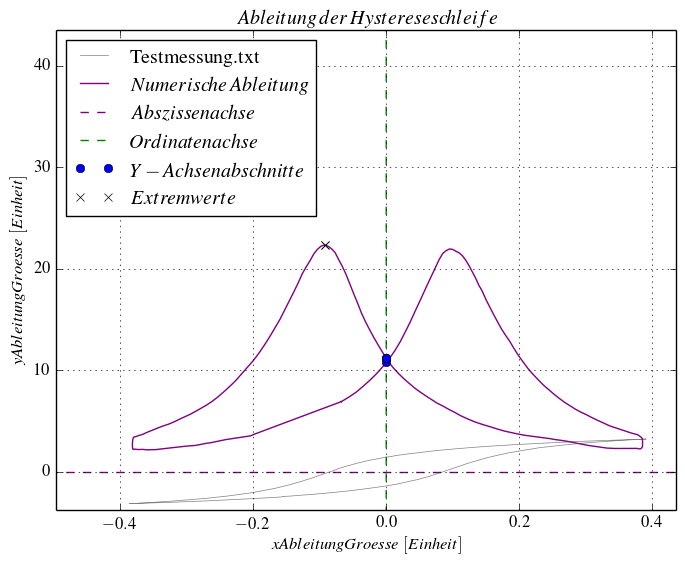


Die Y-Achsenabschnitte liegen bei ca.:
(x,y)= (0, 10.773209365017337)
(x,y)= (0, 11.197598557439576)

Die extremalen Werte liegen bei ca.:
(x,y)= (-0.09285623619024946,22.357184308559965)


In [12]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Datei, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

################################################################################################################################

# Benutze onelclockround
x_oneclockround = []
y_oneclockround = []
onlyoneclockround2(x,y)

################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockround, y_oneclockround)

################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(Nullstellen[1][1] + Nullstellen[2][1])
ρ = 0.5*(Nullstellen[1][2] + Nullstellen[2][2])
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_verschoben, y_verschoben)

################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
YAchsenabschnitte = []
YA(x_verschoben, y_verschoben)

################################################################################################################################

# Plotte Daten
#---------------
plot(x_verschoben, y_verschoben, color="gray", linewidth=0.5, label=Datei) #(Hystereseschleife)

# NUMERISCHE ABLEITUNG (Nur GLATT)
a, b = difference_quotient(x_verschoben, y_verschoben, nGlatte_Ableitung)
plot(a, b, color="purple", label=L"Numerische \, Ableitung")

################################################################################################################################

# Suche Y-Achsenabschnitt und gebe aus
YAchsenabschnitte = []
YA(a, b)

################################################################################################################################

# Suche Extremwerte
Minimas = []
Maximas = []
MAXIMUM(a, b)
MINIMUM(a, b)

################################################################################################################################

# "Plot axis" 
xa = linspace(-halbeAchsenlänge,halbeAchsenlänge, Achsenlängenwerte)
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*xa, xa, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x)+Prozent*minimum(x),maximum(x)+Prozent*maximum(x)])
ax[:set_ylim]([minimum(y)+Prozent*minimum(y),maximum(quotient)+3*Prozent*maximum(quotient)])

# Plotte Y-Achsenabschnitte
for i in 1:length(YAchsenabschnitte)
    plot(YAchsenabschnitte[i][1], YAchsenabschnitte[i][2], "bo")
end
    plot(YAchsenabschnitte[length(YAchsenabschnitte)][1], YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label=L"Y-Achsenabschnitte" )

# Plotte maximalen und minimalen Wert
for i in 1:length(Maximas)
    plot(Maximas[i][1], Maximas[i][2], "kx")
end
for i in 1:length(Minimas)
    plot(Minimas[i][1], Minimas[i][2], "kx")
end
plot(Maximas[length(Maximas)][1], Maximas[length(Maximas)][2], "kx", label=L"Extremwerte" )

# Überschrift des PLotts
title(L"Ableitung \, der \, Hystereseschleife")

# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel(YLABELABLEITUNG)
legend(loc="upper left")
grid()

################################################################################################################################

# Gebe Y-Achsenabschnitte aus
println()
println("Die Y-Achsenabschnitte liegen bei ca.:")
for i in 1:length(YAchsenabschnitte)
    println("(x,y)= ", "(", 0, ", ",YAchsenabschnitte[i][2], ")")
end

# Gebe Extremale Werte aus:
println()
println("Die extremalen Werte liegen bei ca.:")
for i in 1:length(Minimas)
    println("(x,y)= ", Minimas[i])
end
for i in 1:length(Maximas)
    println("(x,y)= ", Maximas[i])
end

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

# ======================================================
# PRAKTIKUMSAUSWERTUNG:
# ======================================================

# Teil 3.3.1

# zusätzliche Funktionen

In [13]:
# Diese Funktion rechnet unsere Messdaten von Volt in Ampere pro meter um.
function Einheiten_umrechner(x_verschoben, y_verschoben, N, Imax, R, Umax, ν, ns, q, μo = 4*π*1e-7)
    for x in x_verschoben
        # x = H(φ) = I_H *N/ℓ = U_H *N/(R*ℓ) = U_H * N/((Umax/Imax)*ℓ) = ((N*Imax)/(ℓ*Umax))*U_H = ((N*Imax)/(2*π*r*Umax))*U_H
        
        xnew = ((N*Imax)/(2*π*R*Umax))*x 
        push!(x_gute_Einheiten, xnew)
    end
    for y in y_verschoben 
        # y = M(φ) = <U_M>/(47*4*ν*ns*q*μo) (Siehe Gleichung (2.5) Praktikumsanleitung Stand Juni 2013)
        
        ynew = y/(47*4*ν*ns*q*μo) 
        push!(y_gute_Einheiten, ynew)
    end
end

Einheiten_umrechner (generic function with 2 methods)

In [14]:
# Diese Funktion berechnet den Fehler für unsere Größen und gibt diese als Tupel aus
function OurErrors(M_H_tupel, Umax, ν, ns, N, R, q, μo = 4*π*1e-7)
    Errortupel = []
    for i in 1:length(M_H_tupel)
        if i == 1
            M_H_tupel[i] = ((N*Imax*0.001*M_H_tupel[i])/(2*π*R*Umax)) 
            elseif i == 2
            # R = Umax/Imax
            M_H_tupel[i] = (Imax*0.001*M_H_tupel[i])/(47*4*ν*ns*q*μo*Umax)
        end
        push!(Errortupel, M_H_tupel[i])
    end
    return Errortupel
end

OurErrors (generic function with 2 methods)

## 3.3.1a


# INPUT 


In [15]:
# txtDateien zum auslesen
DreiAmpere = "331a.txt"

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. Koordinatenachsenlänge
halbeAchsenlänge = 100 
Achsenlängenwerte = 1000

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 7

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"magn.\, Feldstaerke \, $H$ \, [$10^2$A$\cdot$m$^{-1}$]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"
XLABELABLEITUNG = L"xAbleitungGroesse \, [Einheit]"
YLABELABLEITUNG = L"yAbleitungGroesse \, [Einheit]"

# bzgl. Formel (2.5) aus der Anleitung: M(φ) = <U_M>/(47*4*ν*ns*q*μo)
ν = 50
ns = 17 # anzahl windungen sekundärspule
q = 0.9*0.01^2

# bzgl. Formel H(φ) = ((N*Imax)/(2*π*r*Umax))*U_H
N = 17 # anzahl windungen primärspule
Imax = 3 
R = 1.5*1e-2 #radius ferritkern

0.015


# Output


In [16]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(DreiAmpere, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

################################################################################################################################

# Benutze onelclockround
x_oneclockround = []
y_oneclockround = []
onlyoneclockround2(x,y)

################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockround, y_oneclockround)

################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(Nullstellen[1][1] + Nullstellen[2][1])
ρ = 0.5*(Nullstellen[1][2] + Nullstellen[2][2])
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Wechsel von Volt zu SI-Einheiten
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschoben, y_verschoben, N, Imax, R, maximum(x_verschoben), ν, ns, q)

#Passe 10ner Potenz von den Achsen an
x_gute_Einheiten = x_gute_Einheiten*1e-2
y_gute_Einheiten = y_gute_Einheiten*1e-3

################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Suche Y-Achsenabschnitt und gebe aus
YAchsenabschnitte = []
YA(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_Einheiten, y_gute_Einheiten, color="black", label=L"bearbeitete \, Messdaten") #(Hystereseschleife) 

# "Plot axis" 
xa = collect(-2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten))
ya = collect(-2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten),maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([minimum(y_gute_Einheiten)+Prozent*minimum(y_gute_Einheiten),maximum(y_gute_Einheiten)+Prozent*maximum(y_gute_Einheiten)])

# Plotte Y-Achsenabschnitte
    plot(YAchsenabschnitte[length(YAchsenabschnitte)][1], YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label=L"Y-Achsenabschnitt" )

# Plotte Nullstellen
    plot(Nullstellen[length(Nullstellen)][1], Nullstellen[length(Nullstellen)][2], "ro", label=L"Nullstelle" )

# Plotte maximalen und minimalen Wert
plot(maximum(x_gute_Einheiten), maximum(y_gute_Einheiten), "kx", label=L"Maximaler \, Wert")

# Überschrift des PLotts
title("Hystereseschleife  fuer  3 A  Spitzenstromstaerke")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="upper left")
grid()

################################################################################################################################

################################################################################################################################

# Gebe Y-Achsenabschnitte aus
println()
println("Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:")
for i in 2:length(YAchsenabschnitte)
    println("(x,y) = ", "(", 0, ", ",YAchsenabschnitte[i][2], ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel,0)
push!(M_H_tupel, YAchsenabschnitte[2][2])
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")

################################################################################################################################

# Gebe Nullstellen aus
println()
println("Die negative Nullstelle (H_C) liegt bei ca.:")
for i in 2:length(Nullstellen)
    println("(x,y) = ", "(", Nullstellen[i][1], ", ", 0, ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, Nullstellen[2][1])
push!(M_H_tupel, 0)
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")


################################################################################################################################

# Gebe Extremale Werte aus:
println()
println("Der maximale Wert (H_max, M_S) liegt bei ca.:")
println("(x,y) = ", "(", maximum(x_gute_Einheiten), ", ", maximum(y_gute_Einheiten), ")")

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, maximum(x_gute_Einheiten))
push!(M_H_tupel, maximum(y_gute_Einheiten))
OurErrors(M_H_tupel, maximum(_gute_Einheiten), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")


################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################


Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:
(x,y) = (0, 129.32143759397078)

Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:
(x,y) = (Any[0.0,2146.3896560088324])

Die negative Nullstelle (H_C) liegt bei ca.:
(x,y) = (-0.07383624848465012, 0)

Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:
(x,y) = (Any[-0.003994979986748056,0.0])

Der maximale Wert (H_max, M_S) liegt bei ca.:
(x,y) = (5.411268065124441, 315.40964865931113)


LoadError: LoadError: UndefVarError: _gute_Einheiten not defined
while loading In[16], in expression starting on line 163

# 3.3.1b

# Zusätzliche Funktion die einen FEHLER behoben hat

In [17]:
# Diese Funktion läuft Messwerte einmal MIT(!!!!!!) den Uhrzeigersinn ab und schmeißt überflüssige Werte raus. (Besser gesagt: ignoriert überflüssige Werte...)
# Damit wurde EIN/DAS Problem behoben.
function onlyoneclockround1(x, y, i=1, ϵ = 0.005)
    
    x1 = x[i]
    y1 = y[i]
    
    push!(x_oneclockround, x1)
    push!(y_oneclockround, y1)
    
    i = i + 1
    while x1 + ϵ*x1 > x[i]
        push!(x_oneclockround, x[i])
        push!(y_oneclockround, y[i])
        i+=1
    end
    while x[i] > x1 - ϵ*x1
        push!(x_oneclockround, x[i])
        push!(y_oneclockround, y[i])
        i+=1
    end
    i = i-1
    if x[i] < x1
        x_oneclockround[i] = x1
        y_oneclockround[i] = y1
        elseif x[i] > x1
        push!(x_oneclockround, x1)
        push!(y_oneclockround, y1)
    end
end

onlyoneclockround1 (generic function with 3 methods)

# Input

In [18]:
# txtDateien zum auslesen
EinAmpere = "331b.txt" #"331-1AmpereV2TestB.txt"

# Überschrift des Plotts
TITEL ="Hystereseschleife  fuer  1 A  Spitzenstromstaerke"

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 7

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"magn.\, Feldstaerke \, $H$ \, [$10^2$A$\cdot$m$^{-1}$]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"
XLABELABLEITUNG = L"xAbleitungGroesse \, [Einheit]"
YLABELABLEITUNG = L"yAbleitungGroesse \, [Einheit]"

# bzgl Achsenlängen
#linspace(-400, 400, 100)

# bzgl. Formel (2.5) aus der Anleitung: M(φ) = <U_M>/(47*4*ν*ns*q*μo)
ν = 50
ns = 17
q = 0.9*0.01^2

# bzgl. Formel H(φ) = ((N*Imax)/(2*π*r*Umax))*U_H
N = 17
Imax = 1 
R = 1.5*1e-2

0.015

# Output

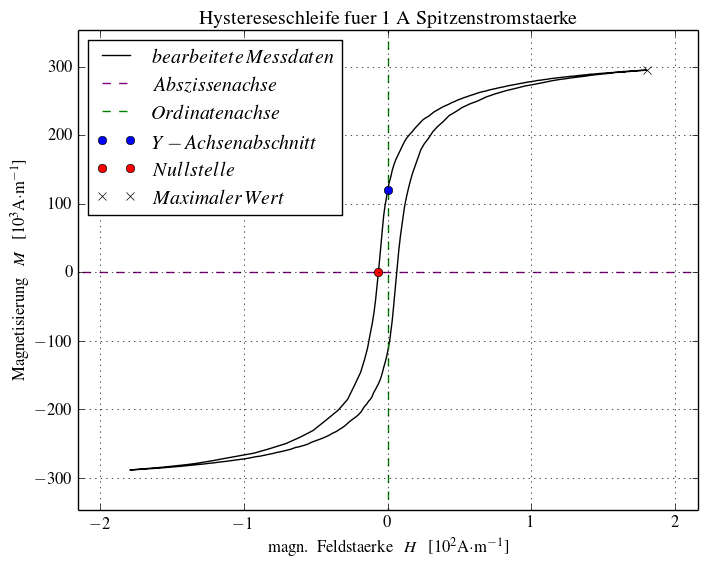


Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:
(x,y) = (0, 119.90560153278007)

Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:
(x,y) = (Any[0.0,1948.163516789441])

Die negative Nullstelle (H_C) liegt bei ca.:
(x,y) = (-0.06419565670184942, 0)

Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:
(x,y) = (Any[-0.0034001534883275177,0.0])

Der maximale Wert (H_max, M_S) liegt bei ca.:
(x,y) = (1.8037560217081472, 295.4772349729112)

Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:
(x,y) = (Any[0.09553679554657528,4800.759613041743])


In [19]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(EinAmpere, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

# ################################################################################################################################

# Benutze onelclockround
x_oneclockround = []
y_oneclockround = []
onlyoneclockround1(x,y)

################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockround, y_oneclockround)

################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(Nullstellen[1][1] + Nullstellen[2][1])
ρ = 0.5*(Nullstellen[1][2] + Nullstellen[2][2])
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Wechsel von Volt zu SI-Einheiten
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschoben, y_verschoben, N, Imax, R, maximum(x_verschoben), ν, ns, q)

#Passe 10ner Potenz von den Achsen an
x_gute_Einheiten = x_gute_Einheiten*1e-2
y_gute_Einheiten = y_gute_Einheiten*1e-3

################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Suche Y-Achsenabschnitt und gebe aus
YAchsenabschnitte = []
YA(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_Einheiten, y_gute_Einheiten, color="black", label=L"bearbeitete \, Messdaten") #(Hystereseschleife) 

# "Plot axis"
xa = collect(-2*maximum(x_gute_Einheiten):0.5maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten))
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten),maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([minimum(y_gute_Einheiten)+Prozent*minimum(y_gute_Einheiten),maximum(y_gute_Einheiten)+Prozent*maximum(y_gute_Einheiten)])

# Plotte Y-Achsenabschnitte
    plot(YAchsenabschnitte[length(YAchsenabschnitte)][1], YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label=L"Y-Achsenabschnitt" )

# Plotte Nullstellen
    plot(Nullstellen[length(Nullstellen)][1], Nullstellen[length(Nullstellen)][2], "ro", label=L"Nullstelle" )

# Plotte maximalen und minimalen Wert
plot(maximum(x_gute_Einheiten), maximum(y_gute_Einheiten), "kx", label=L"Maximaler \, Wert")

# Überschrift des PLotts
title(TITEL)

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="upper left")
grid()

################################################################################################################################

################################################################################################################################

# Gebe Y-Achsenabschnitte aus
println()
println("Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:")
for i in 2:length(YAchsenabschnitte)
    println("(x,y) = ", "(", 0, ", ",YAchsenabschnitte[i][2], ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel,0)
push!(M_H_tupel, YAchsenabschnitte[2][2])
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")

################################################################################################################################

# Gebe Nullstellen aus
println()
println("Die negative Nullstelle (H_C) liegt bei ca.:")
for i in 2:length(Nullstellen)
    println("(x,y) = ", "(", Nullstellen[i][1], ", ", 0, ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, Nullstellen[2][1])
push!(M_H_tupel, 0)
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")


################################################################################################################################

# Gebe Extremale Werte aus:
println()
println("Der maximale Wert (H_max, M_S) liegt bei ca.:")
println("(x,y) = ", "(", maximum(x_gute_Einheiten), ", ", maximum(y_gute_Einheiten), ")")

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, maximum(x_gute_Einheiten))
push!(M_H_tupel, maximum(y_gute_Einheiten))
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")



################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

# 3.3.1c

# INPUT

In [20]:
# txtDateien zum auslesen
DreihundertMiliampere = "331c.txt"
#HundertMiliampere = ""

# Überschrift des Plotts
TITEL ="Hystereseschleife  fuer  0.3 A  Spitzenstromstaerke"

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 7

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"magn.\, Feldstaerke \, $H$ \, [$10^2$A$\cdot$m$^{-1}$]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"
XLABELABLEITUNG = L"xAbleitungGroesse \, [Einheit]"
YLABELABLEITUNG = L"yAbleitungGroesse \, [Einheit]"

# bzgl Achsenlängen
#linspace(-400, 400, 100)

# bzgl. Formel (2.5) aus der Anleitung: M(φ) = <U_M>/(47*4*ν*ns*q*μo)
ν = 50
ns = 17
q = 0.9*0.01^2

# bzgl. Formel H(φ) = ((N*Imax)/(2*π*r*Umax))*U_H
N = 17
Imax = 0.3 
R = 1.5*1e-2

0.015

# OUTPUT

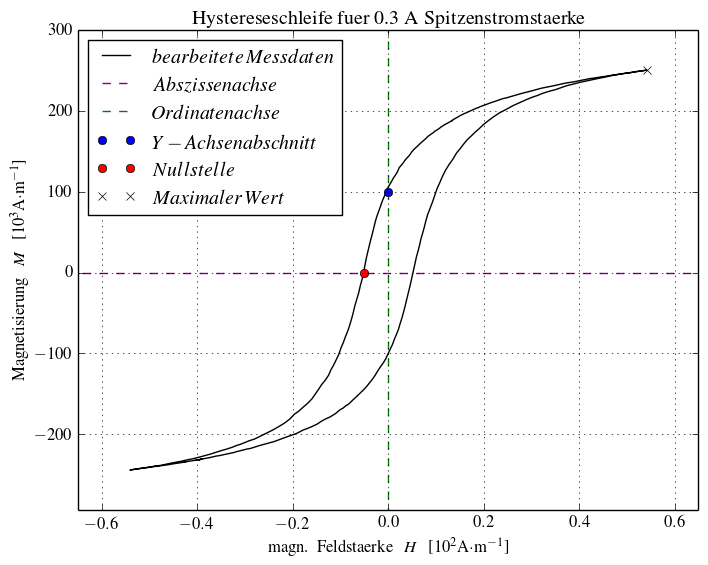


Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:
(x,y) = (0, 99.80143892475071)

Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:
(x,y) = (Any[0.0,1528.5891767767548])

Die negative Nullstelle (H_C) liegt bei ca.:
(x,y) = (0.05184685177985191, 0)

Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:
(x,y) = (Any[0.0025887094565714103,0.0])

Der maximale Wert (H_max, M_S) liegt bei ca.:
(x,y) = (0.5411268065124442, 250.55461799363235)

Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:
(x,y) = (Any[0.02701842123743802,3837.5706941988606])


In [21]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(DreihundertMiliampere, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

# ################################################################################################################################

# Benutze onelclockround
x_oneclockround = []
y_oneclockround = []
onlyoneclockround1(x,y)

################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockround, y_oneclockround)

################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(Nullstellen[1][1] + Nullstellen[2][1])
ρ = 0.5*(Nullstellen[1][2] + Nullstellen[2][2])
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Wechsel von Volt zu SI-Einheiten
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschoben, y_verschoben, N, Imax, R, maximum(x_verschoben), ν, ns, q)

#Passe 10ner Potenz von den Achsen an
x_gute_Einheiten = x_gute_Einheiten*1e-2
y_gute_Einheiten = y_gute_Einheiten*1e-3

################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Suche Y-Achsenabschnitt und gebe aus
YAchsenabschnitte = []
YA(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_Einheiten, y_gute_Einheiten, color="black", label=L"bearbeitete \, Messdaten") #(Hystereseschleife) 

# "Plot axis"
xa = collect(-2*maximum(x_gute_Einheiten):0.5maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten))
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten),maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([minimum(y_gute_Einheiten)+Prozent*minimum(y_gute_Einheiten),maximum(y_gute_Einheiten)+Prozent*maximum(y_gute_Einheiten)])

# Plotte Y-Achsenabschnitte
    plot(-YAchsenabschnitte[length(YAchsenabschnitte)][1], -YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label=L"Y-Achsenabschnitt" )

# Plotte Nullstellen
    plot(-Nullstellen[length(Nullstellen)][1], -Nullstellen[length(Nullstellen)][2], "ro", label=L"Nullstelle" )

# Plotte maximalen und minimalen Wert
plot(maximum(x_gute_Einheiten), maximum(y_gute_Einheiten), "kx", label=L"Maximaler \, Wert")

# Überschrift des PLotts
title(TITEL)

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="upper left")
grid()

################################################################################################################################

################################################################################################################################

# Gebe Y-Achsenabschnitte aus
println()
println("Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:")
for i in 2:length(YAchsenabschnitte)
    println("(x,y) = ", "(", 0, ", ",-YAchsenabschnitte[i][2], ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel,0)
push!(M_H_tupel, -YAchsenabschnitte[2][2])
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")

################################################################################################################################

# Gebe Nullstellen aus
println()
println("Die negative Nullstelle (H_C) liegt bei ca.:")
for i in 2:length(Nullstellen)
    println("(x,y) = ", "(", Nullstellen[i][1], ", ", 0, ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, Nullstellen[2][1])
push!(M_H_tupel, 0)
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")


################################################################################################################################

# Gebe Extremale Werte aus:
println()
println("Der maximale Wert (H_max, M_S) liegt bei ca.:")
println("(x,y) = ", "(", maximum(x_gute_Einheiten), ", ", maximum(y_gute_Einheiten), ")")

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, maximum(x_gute_Einheiten))
push!(M_H_tupel, maximum(y_gute_Einheiten))
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")


################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

# 3.3.1d

# Input

In [22]:
# txtDateien zum auslesen
HundertMiliampere = "331d.txt"

# Überschrift des Plotts
TITEL ="Hystereseschleife  fuer  0.1 A  Spitzenstromstaerke"

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 7

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"magn.\, Feldstaerke \, $H$ \, [$10^2$A$\cdot$m$^{-1}$]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"
XLABELABLEITUNG = L"xAbleitungGroesse \, [Einheit]"
YLABELABLEITUNG = L"yAbleitungGroesse \, [Einheit]"

# bzgl Achsenlängen
#linspace(-400, 400, 100)

# bzgl. Formel (2.5) aus der Anleitung: M(φ) = <U_M>/(47*4*ν*ns*q*μo)
ν = 50
ns = 17
q = 0.9*0.01^2

# bzgl. Formel H(φ) = ((N*Imax)/(2*π*r*Umax))*U_H
N = 17
Imax = 0.1
R = 1.5*1e-2

0.015

# Output

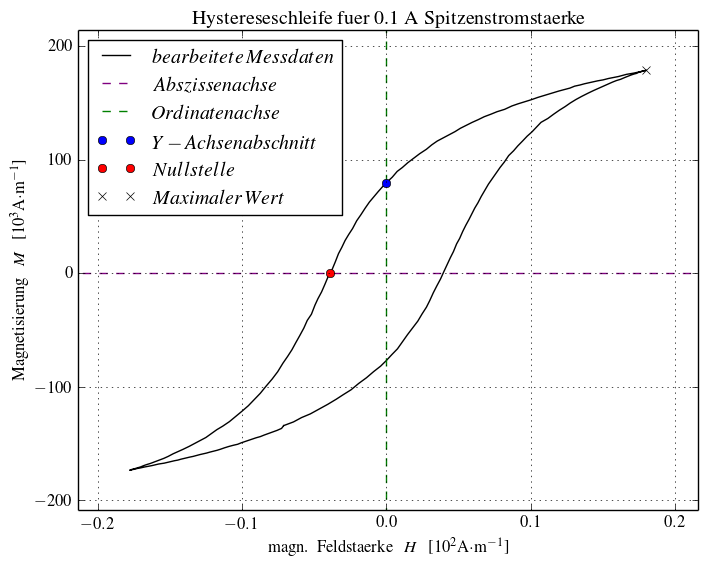


Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:
(x,y) = (0, 79.86466284880646)

Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:
(x,y) = (Any[0.0,1129.9638252753643])

Die negative Nullstelle (H_C) liegt bei ca.:
(x,y) = (-0.03927525779866962, 0)

Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:
(x,y) = (Any[-0.001811489680579364,0.0])

Der maximale Wert (H_max, M_S) liegt bei ca.:
(x,y) = (0.18037560217081477, 178.93324749618955)

Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:
(x,y) = (Any[0.008319449960982503,2531.6340118095104])


In [23]:
# ################################################################################################################################
################################################################################################################################
file = open(HundertMiliampere, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

# ################################################################################################################################

# Benutze onelclockround
x_oneclockround = []
y_oneclockround = []
onlyoneclockround2(x,y)

################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockround, y_oneclockround)

################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(Nullstellen[1][1] + Nullstellen[2][1])
ρ = 0.5*(Nullstellen[1][2] + Nullstellen[2][2])
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Wechsel von Volt zu SI-Einheiten
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschoben, y_verschoben, N, Imax, R, maximum(x_verschoben), ν, ns, q)

#Passe 10ner Potenz von den Achsen an
x_gute_Einheiten = x_gute_Einheiten*1e-2
y_gute_Einheiten = y_gute_Einheiten*1e-3

################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Suche Y-Achsenabschnitt und gebe aus
YAchsenabschnitte = []
YA(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_Einheiten, y_gute_Einheiten, color="black", label=L"bearbeitete \, Messdaten") #(Hystereseschleife) 

# "Plot axis"
xa = collect(-2*maximum(x_gute_Einheiten):0.5maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten))
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten),maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([minimum(y_gute_Einheiten)+Prozent*minimum(y_gute_Einheiten),maximum(y_gute_Einheiten)+Prozent*maximum(y_gute_Einheiten)])

# Plotte Y-Achsenabschnitte
    plot(YAchsenabschnitte[length(YAchsenabschnitte)][1], YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label=L"Y-Achsenabschnitt" )

# Plotte Nullstellen
    plot(Nullstellen[length(Nullstellen)][1], Nullstellen[length(Nullstellen)][2], "ro", label=L"Nullstelle" )

# Plotte maximalen und minimalen Wert
plot(maximum(x_gute_Einheiten), maximum(y_gute_Einheiten), "kx", label=L"Maximaler \, Wert")

# Überschrift des PLotts
title(TITEL)

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="upper left")
grid()

################################################################################################################################

################################################################################################################################

# Gebe Y-Achsenabschnitte aus
println()
println("Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:")
for i in 2:length(YAchsenabschnitte)
    println("(x,y) = ", "(", 0, ", ",YAchsenabschnitte[i][2], ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel,0)
push!(M_H_tupel, YAchsenabschnitte[2][2])
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")

################################################################################################################################

# Gebe Nullstellen aus
println()
println("Die negative Nullstelle (H_C) liegt bei ca.:")
for i in 2:length(Nullstellen)
    println("(x,y) = ", "(", Nullstellen[i][1], ", ", 0, ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, Nullstellen[2][1])
push!(M_H_tupel, 0)
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")


################################################################################################################################

# Gebe Extremale Werte aus:
println()
println("Der maximale Wert (H_max, M_S) liegt bei ca.:")
println("(x,y) = ", "(", maximum(x_gute_Einheiten), ", ", maximum(y_gute_Einheiten), ")")

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, maximum(x_gute_Einheiten))
push!(M_H_tupel, maximum(y_gute_Einheiten))
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

------------
# Teil 3.3.2
 ------------

# 332a

# Input

In [24]:
# txtDateien zum auslesen
KommkurveDreiA = "332a.txt"

# Überschrift des Plotts
TITEL ="Kommutierungskurve  fuer  3 A  maximale Spitzenstromstaerke"

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 7

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"magn.\, Feldstaerke \, $H$ \, [A$\cdot$m$^{-1}$]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"
XLABELABLEITUNG = L"magn.\, Feldstaerke \, $H$ \, [A$\cdot$m$^{-1}$]"
YLABELABLEITUNG = L"differentielle \, Suszeptibilitaet \, $\chi_{diff}$"

# bzgl Achsenlängen
#linspace(-400, 400, 100)

# bzgl. Formel (2.5) aus der Anleitung: M(φ) = <U_M>/(47*4*ν*ns*q*μo)
ν = 50
ns = 17
q = 0.9*0.01^2

# bzgl. Formel H(φ) = ((N*Imax)/(2*π*r*Umax))*U_H
N = 17
Imax = 3
R = 1.5*1e-2

0.015

# Output

9.84746933


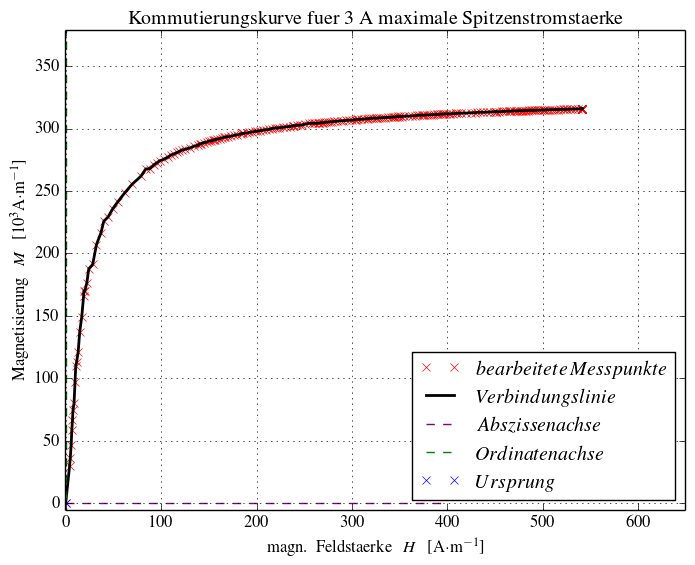

541.1268065124442


In [25]:
# ################################################################################################################################
################################################################################################################################
file = open(KommkurveDreiA, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

println(maximum(x))

# ################################################################################################################################

# Benutze onelclockround
x_oneclockround = []
y_oneclockround = []
onlyoneclockround1(x,y)

#Schmeiße Werte raus die mich nicht interessieren
x = []
y = []
for i in 0:length(x_oneclockround)
    if i==0
        push!(x,r)
        push!(y,ρ)
        else
        if y_oneclockround[i] > 0
            push!(x,x_oneclockround[i])
            push!(y,y_oneclockround[i])
        end
    end
end

x_oneclockround = []
y_oneclockround = []
for i in 1:length(x)
    push!(x_oneclockround, x[i])
    push!(y_oneclockround, y[i])
end

x = []
y = []
i=1
while x_oneclockround[i] < maximum(x_oneclockround)
    i = i+1
end
while i< length(x_oneclockround)
    push!(x,x_oneclockround[i])
    push!(y,y_oneclockround[i])
    i = i+1
end
    push!(x,x_oneclockround[i])
    push!(y,y_oneclockround[i])

x_oneclockround = []
y_oneclockround = []
for i in 1:length(x)
    push!(x_oneclockround, x[i])
    push!(y_oneclockround, y[i])
end
push!(x_oneclockround, r)
push!(y_oneclockround, ρ)
################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Wechsel von Volt zu SI-Einheiten
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschoben, y_verschoben, N, Imax, R, maximum(x_verschoben), ν, ns, q)

#Passe 10ner Potenz von den Achsen an
#x_gute_Einheiten = x_gute_Einheiten*1e-2
y_gute_Einheiten = y_gute_Einheiten*1e-3

################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_Einheiten, y_gute_Einheiten, "rx", label=L"bearbeitete \, Messpunkte")
plot(x_gute_Einheiten, y_gute_Einheiten, color="black", linewidth=2.0, label=L"Verbindungslinie") 

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten) - 0.2,maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([-5,maximum(y_gute_Einheiten)+Prozent*maximum(y_gute_Einheiten)])

#plotte Ursprung da ich diesen künstlich zu den Messdaten hinzugefügt habe

plot(0,0,"bx",label=L"Ursprung")

# Überschrift des PLotts
title(TITEL)

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

################################################################################################################################
println(maximum(x_gute_Einheiten))
################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

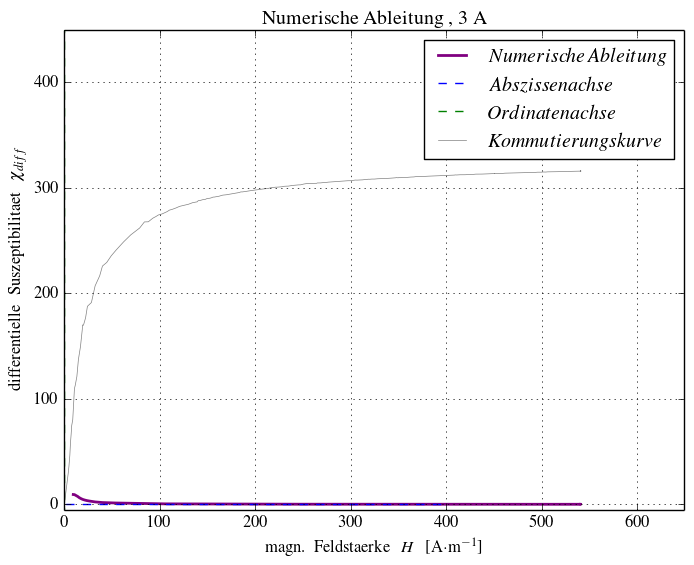

In [26]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(KommkurveDreiA, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################


# NUMERISCHE ABLEITUNG (Nur GLATT)
a, b = difference_quotient(x_gute_Einheiten, y_gute_Einheiten, nGlatte_Ableitung)
xab = []
yab = []
for i in 1:length(a)-1
    push!(xab, a[i])
    push!(yab, b[i])
end

PLOTdreiamp = plot(xab, yab, color="purple",linewidth=2.0, label=L"Numerische \, Ableitung")
xDREI = xab 
yDREI = yab 
################################################################################################################################

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="blue", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten) - 0.2,maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([-5,450])

# Überschrift des PLotts
title("Numerische  Ableitung , 3 A")

# plotte kommkurve
plot(x_gute_Einheiten, y_gute_Einheiten, color="gray", linewidth=0.5, label=L"Kommutierungskurve") 

# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel(YLABELABLEITUNG)
legend(loc="upper right")
grid()

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

# 332b

# Input

In [27]:
# txtDateien zum auslesen
KommkurveHundertmilliA = "332b.txt"

# Überschrift des Plotts
TITEL ="Kommutierungskurve  fuer  100 mA  maximale Spitzenstromstaerke"

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 25

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"magn.\, Feldstaerke \, $H$ \, [A$\cdot$m$^{-1}$]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"
XLABELABLEITUNG = L"magn.\, Feldstaerke \, $H$ \, [A$\cdot$m$^{-1}$]"
YLABELABLEITUNG = L"differentielle \, Suszeptibilitaet \, $\chi_{diff}$"

# bzgl Achsenlängen
#linspace(-400, 400, 100)

# bzgl. Formel (2.5) aus der Anleitung: M(φ) = <U_M>/(47*4*ν*ns*q*μo)
ν = 50
ns = 17
q = 0.9*0.01^2

# bzgl. Formel H(φ) = ((N*Imax)/(2*π*r*Umax))*U_H
N = 17
Imax = 0.1
R = 1.5*1e-2

0.015

0.266467214
18

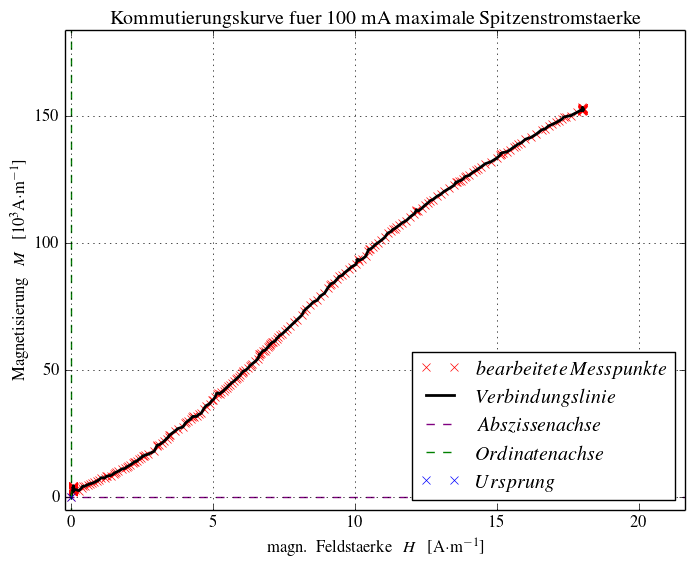

.037560217081474


In [28]:
# ################################################################################################################################
################################################################################################################################
file = open(KommkurveHundertmilliA , "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

println(maximum(x))

# ################################################################################################################################

# Benutze onelclockround
x_oneclockround = x
y_oneclockround = y
#onlyoneclockround2(x,y)

#Schmeiße Werte raus die mich nicht interessieren
x = []
y = []
for i in 0:length(x_oneclockround)
    if i==0
        push!(x,r)
        push!(y,ρ)
        else
        if y_oneclockround[i] > 0
            push!(x,x_oneclockround[i])
            push!(y,y_oneclockround[i])
        end
    end
end

x_oneclockround = []
y_oneclockround = []
for i in 1:length(x)
    push!(x_oneclockround, x[i])
    push!(y_oneclockround, y[i])
end

x = []
y = []
i=1
while x_oneclockround[i] < maximum(x_oneclockround)
    i = i+1
end
while i< length(x_oneclockround)
    push!(x,x_oneclockround[i])
    push!(y,y_oneclockround[i])
    i = i+1
end
    push!(x,x_oneclockround[i])
    push!(y,y_oneclockround[i])

x_oneclockround = []
y_oneclockround = []
for i in 1:length(x)
    push!(x_oneclockround, x[i])
    push!(y_oneclockround, y[i])
end
push!(x_oneclockround, r)
push!(y_oneclockround, ρ)
################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Wechsel von Volt zu SI-Einheiten
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschoben, y_verschoben, N, Imax, R, maximum(x_verschoben), ν, ns, q)

#Passe 10ner Potenz von den Achsen an
#x_gute_Einheiten = x_gute_Einheiten*1e-2
y_gute_Einheiten = y_gute_Einheiten*1e-3

################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_Einheiten, y_gute_Einheiten, "rx", label=L"bearbeitete \, Messpunkte")
plot(x_gute_Einheiten, y_gute_Einheiten, color="black", linewidth=2.0, label=L"Verbindungslinie") 

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten) - 0.2,maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([-5,maximum(y_gute_Einheiten)+Prozent*maximum(y_gute_Einheiten)])

#plotte Ursprung da ich diesen künstlich zu den Messdaten hinzugefügt habe

plot(0,0,"bx",label=L"Ursprung")

# Überschrift des PLotts
title(TITEL)

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

################################################################################################################################
println(maximum(x_gute_Einheiten))
################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

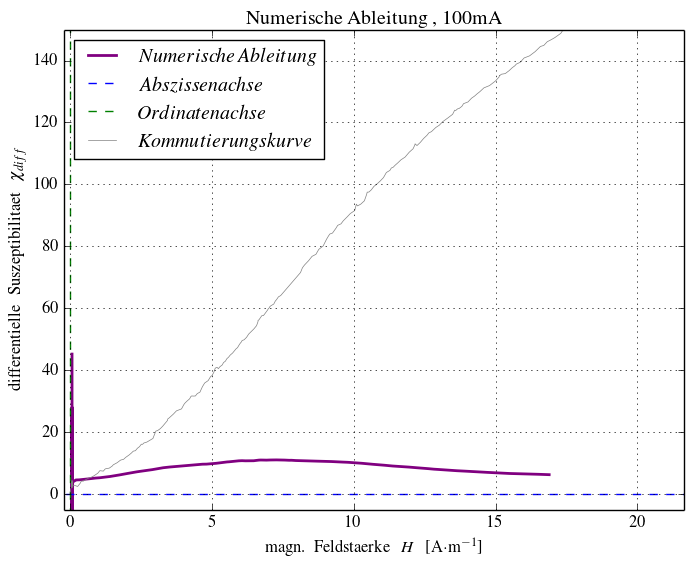

In [29]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(KommkurveHundertmilliA, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################


# NUMERISCHE ABLEITUNG (Nur GLATT)
a, b = difference_quotient(x_gute_Einheiten, y_gute_Einheiten, nGlatte_Ableitung)
xab = []
yab = []
#schmeiße hässlichen Teil vorne und hinten raus
for i in 1:length(a)-1
    push!(xab, a[i])
    push!(yab, b[i])
end

plot(xab, yab, color="purple",linewidth=2.0, label=L"Numerische \, Ableitung")
xNULLKOMMA = xab 
yNULLKOMMA = yab 

################################################################################################################################

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="blue", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten) - 0.2,maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([-5,150])

# Überschrift des PLotts
title("Numerische  Ableitung , 100mA")

# plotte kommkurve
plot(x_gute_Einheiten, y_gute_Einheiten, color="gray", linewidth=0.5, label=L"Kommutierungskurve") 

# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel(YLABELABLEITUNG)
legend(loc="upper left")
grid()

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

# 332a+332b (gemeinsamer Graph)

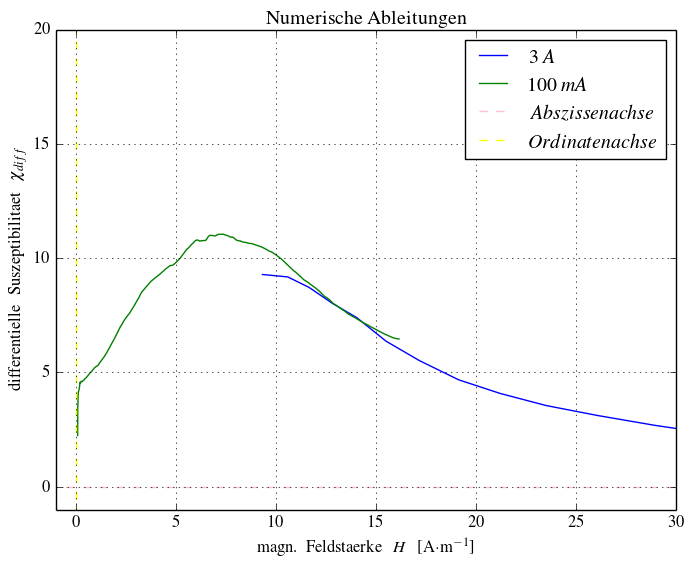

In [30]:
plot(xDREI, yDREI, label=L"3 \,\, A")

#schmeiße den Müll der nicht stetg diffbar ist vorne raus...
xNULLKOMMAs = []
yNULLKOMMAs = []
Müllvorne = 35
for i in 10:length(xNULLKOMMA)-85
    push!(xNULLKOMMAs, xNULLKOMMA[i])
    push!(yNULLKOMMAs, yNULLKOMMA[i])
end
plot(xNULLKOMMAs, yNULLKOMMAs, label=L"100 \,\,mA")

################################################################################################################################
# "Plot axis"
xa = linspace(-400, 800, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="pink", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="yellow", linestyle="--", label=L"Ordinatenachse")
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([-1,30])
ax[:set_ylim]([-1,20])
# Überschrift des PLotts
title("Numerische  Ableitungen")
# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel(YLABELABLEITUNG)
legend(loc="upper right")
grid()

# Teil 3.3.3

# Funktionen

In [31]:
# Diese Funktion rechnet unsere Messdaten von Volt in Ampere pro meter um.
function Einheiten_umrechner2(x_verschoben, y_verschoben, N, Imax, R, Umax, ν, ns, q, μo = 4*π*1e-7)
    for x in x_verschoben
        # Temperatur in Kelvin umrechnen
        
        xnew = x + 273.15 
        push!(x_gute_Einheiten, xnew)
    end
    for y in y_verschoben 
        # y = M(φ) = <U_M>/(47*4*ν*ns*q*μo) (Siehe Gleichung (2.5) Praktikumsanleitung Stand Juni 2013)
        
        ynew = y/(47*4*ν*ns*q*μo) 
        push!(y_gute_Einheiten, ynew)
    end
end

Einheiten_umrechner2 (generic function with 2 methods)

# Input

In [32]:
# txtDateien zum auslesen
Temperaturmessung = "333.txt"

# Überschrift des Plotts
TITEL ="Magnetisierung in Abhaengigkeit der Temperatur"

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 35

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"Temperatur \, $T$ \, [K]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"
XLABELABLEITUNG = L"Temperatur \, $T$ \, [K]"
YLABELABLEITUNG = L"Numerische \, Ableitung \, $\frac{\partial M}{\partial T}$ \, [$10^3$A$\cdot$m$^{-1} \cdot$ K$^{-1}$ ]"

# bzgl Achsenlängen
#linspace(-400, 400, 100)

# bzgl. Formel (2.5) aus der Anleitung: M(φ) = <U_M>/(47*4*ν*ns*q*μo)
ν = 50
ns = 17
q = 0.9*0.01^2

# bzgl. Formel H(φ) = ((N*Imax)/(2*π*r*Umax))*U_H
N = 17
Imax = 0.1
R = 1.5*1e-2

0.015

# Output

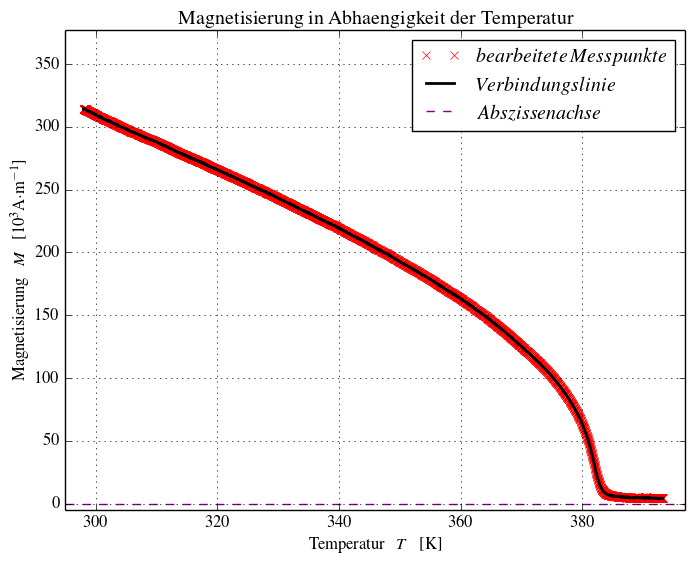

In [33]:
# ################################################################################################################################
################################################################################################################################
file = open(Temperaturmessung , "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

# Wechsel von Volt zu SI-Einheiten
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner2(x, y, N, Imax, R, maximum(x), ν, ns, q)

#Passe 10ner Potenz von den Achsen an
#x_gute_Einheiten = x_gute_Einheiten*1e-2
y_gute_Einheiten = y_gute_Einheiten*1e-3

################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_Einheiten, y_gute_Einheiten, "rx", label=L"bearbeitete \, Messpunkte")
plot(x_gute_Einheiten, y_gute_Einheiten, color="black", linewidth=2.0, label=L"Verbindungslinie") 

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
#plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([295,397])
ax[:set_ylim]([-5,maximum(y_gute_Einheiten)+Prozent*maximum(y_gute_Einheiten)])

#plotte Ursprung da ich diesen künstlich zu den Messdaten hinzugefügt habe

#plot(0,0,"bx",label=L"Ursprung")

# Überschrift des PLotts
title(TITEL)

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="upper right")
grid()

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

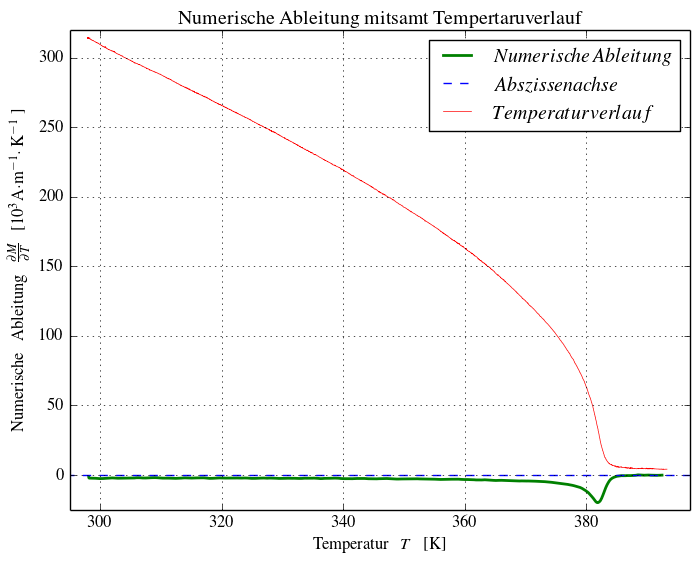

In [34]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Temperaturmessung , "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################


# NUMERISCHE ABLEITUNG (Nur GLATT)
a, b = difference_quotient(x_gute_Einheiten, y_gute_Einheiten, nGlatte_Ableitung)
xab = []
yab = []
#schmeiße hässlichen Teil vorne und hinten raus
for i in 1:length(a)-1
    push!(xab, a[i])
    push!(yab, b[i])
end

plot(xab, yab, color="green",linewidth=2.0, label=L"Numerische \, Ableitung")
xNULLKOMMA = xab 
yNULLKOMMA = yab 

################################################################################################################################

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="blue", linestyle="--", label=L"Abszissenachse")
#plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([295,397])
ax[:set_ylim]([-25,320])

# Überschrift des PLotts
title("Numerische Ableitung mitsamt Tempertaruverlauf")

# plotte kommkurve
plot(x_gute_Einheiten, y_gute_Einheiten, color="red", linewidth=0.5, label=L"Temperaturverlauf") 

# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel(YLABELABLEITUNG)
legend(loc="upper right")
grid()

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

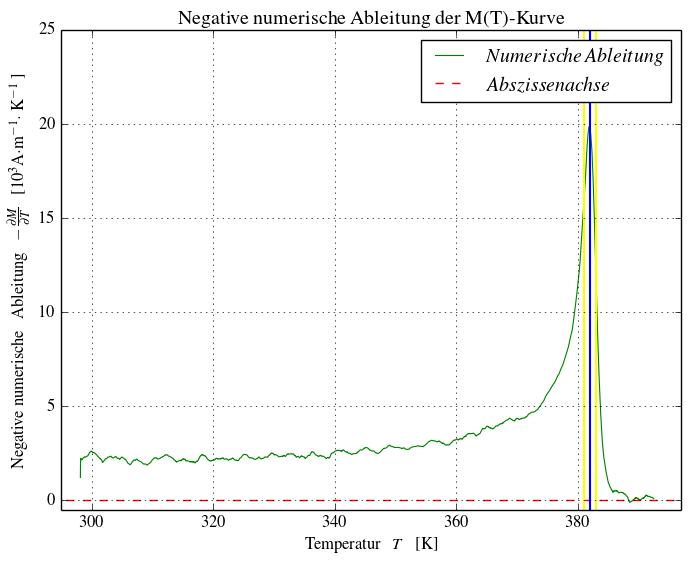

In [35]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Temperaturmessung , "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

# NUMERISCHE ABLEITUNG (Nur GLATT)
a, b = difference_quotient(x_gute_Einheiten, y_gute_Einheiten, nGlatte_Ableitung)
xab = []
yab = []
#schmeiße hässlichen Teil vorne und hinten raus
for i in 1:length(a)-1
    push!(xab, a[i])
    push!(yab, -b[i])
end

plot(xab, yab, color="green",linewidth=0.8, label=L"Numerische \, Ableitung")
xNULLKOMMA = xab 
yNULLKOMMA = yab 

################################################################################################################################

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="red", linestyle="--", label=L"Abszissenachse")
plot(0*ya+382, ya, color="blue", linestyle="-", linewidth=1.5)
plot(0*ya+381, ya, color="yellow", linestyle="-", linewidth=1.5)
plot(0*ya+383, ya, color="yellow", linestyle="-", linewidth=1.5)

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([295,397])
ax[:set_ylim]([-0.5,25])

# Überschrift des PLotts
title("Negative numerische Ableitung der M(T)-Kurve")

# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel( L"Negative numerische \, Ableitung \, $-\frac{\partial M}{\partial T}$ \, [$10^3$A$\cdot$m$^{-1} \cdot$ K$^{-1}$ ]")
legend(loc="upper right")
grid()

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

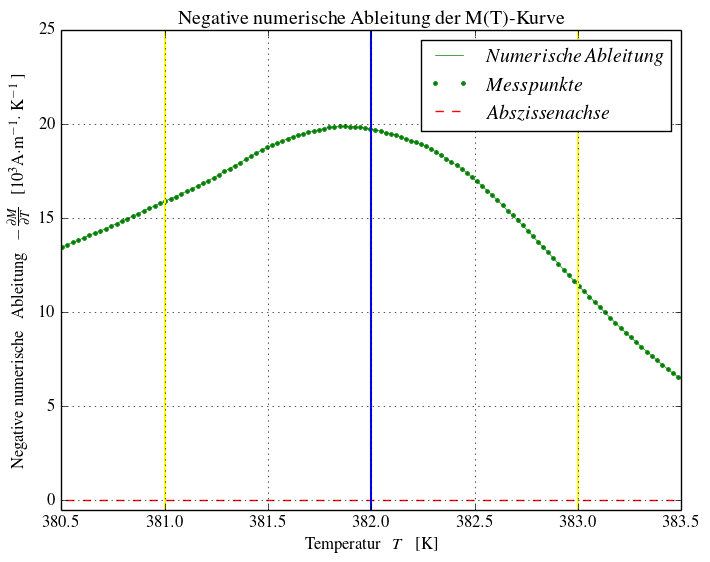

In [36]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Temperaturmessung , "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

# NUMERISCHE ABLEITUNG (Nur GLATT)
a, b = difference_quotient(x_gute_Einheiten, y_gute_Einheiten, nGlatte_Ableitung)
xab = []
yab = []
#schmeiße hässlichen Teil vorne und hinten raus
for i in 1:length(a)-1
    push!(xab, a[i])
    push!(yab, -b[i])
end

plot(xab, yab, color="green",linewidth=0.5, label=L"Numerische \, Ableitung")
plot(xab, yab, "g.",linewidth=1.0, label=L"Messpunkte")
xNULLKOMMA = xab 
yNULLKOMMA = yab 

################################################################################################################################

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="red", linestyle="--", label=L"Abszissenachse")
plot(0*ya+382, ya, color="blue", linestyle="-", linewidth=1.5)
plot(0*ya+381, ya, color="yellow", linestyle="-", linewidth=1.5)
plot(0*ya+383, ya, color="yellow", linestyle="-", linewidth=1.5)

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([380.5,383.5])
ax[:set_ylim]([-0.5,25])

# Überschrift des PLotts
title("Negative numerische Ableitung der M(T)-Kurve")

# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel( L"Negative numerische \, Ableitung \, $-\frac{\partial M}{\partial T}$ \, [$10^3$A$\cdot$m$^{-1} \cdot$ K$^{-1}$ ]")
legend(loc="upper right")
grid()

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

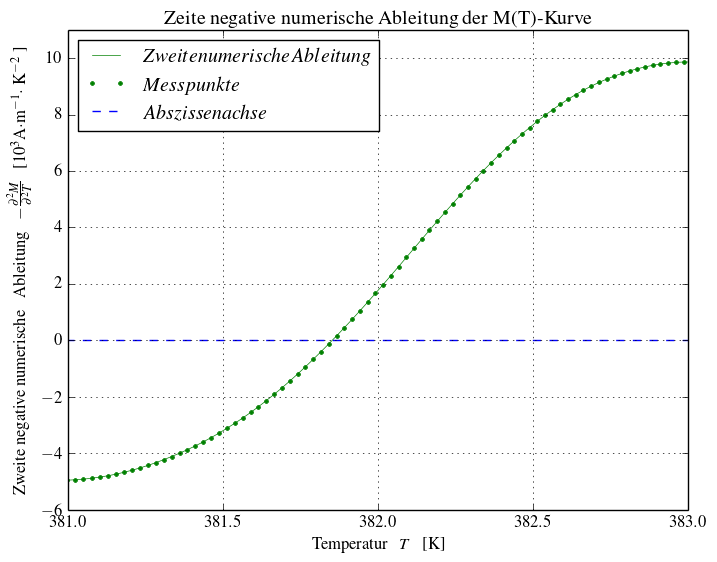

In [37]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Temperaturmessung , "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

# NUMERISCHE ABLEITUNG (Nur GLATT)
a, b = difference_quotient(xab, yab, nGlatte_Ableitung)
xab = []
yab = []
#schmeiße hässlichen Teil vorne und hinten raus
for i in 1:length(a)-1
    push!(xab, a[i])
    push!(yab, -b[i])
end

xabzwo = xab
yabzwo = yab

plot(xab, yab, color="green",linewidth=0.5, label=L"Zweite numerische \, Ableitung")
plot(xab, yab, "g.",linewidth=1.0, label=L"Messpunkte")

################################################################################################################################

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="blue", linestyle="--", label=L"Abszissenachse")
# plot(0*ya+382, ya, color="blue", linestyle="-", linewidth=1.5)
# plot(0*ya+381, ya, color="yellow", linestyle="-", linewidth=1.5)
# plot(0*ya+383, ya, color="yellow", linestyle="-", linewidth=1.5)

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([381,383])
ax[:set_ylim]([-6,11])

# Überschrift des PLotts
title("Zeite negative numerische Ableitung der M(T)-Kurve")

# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel( L"Zweite negative numerische \, Ableitung \, $-\frac{\partial^2 M}{\partial^2 T}$ \, [$10^3$A$\cdot$m$^{-1} \cdot$ K$^{-2}$ ]")
legend(loc="upper left")
grid()

################################################################################################################################

################################################################################################################################

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

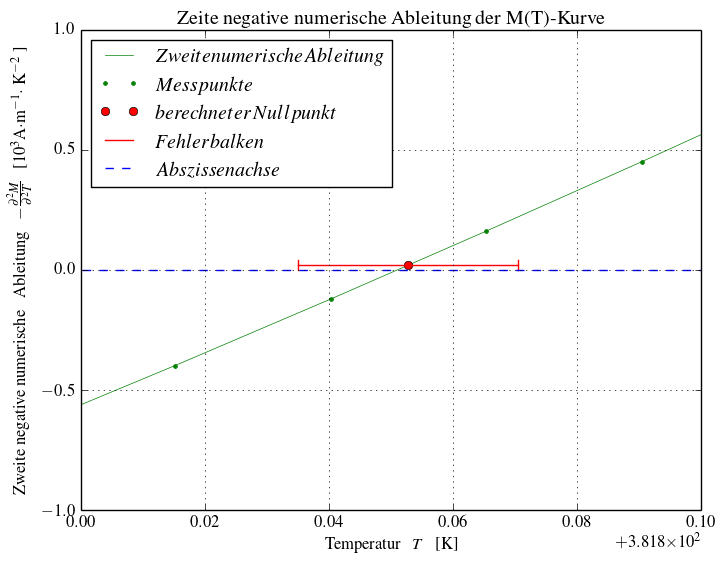

Die Curie Temperatur liegt bei: Tc =381.852777986213
Fehler ist dabei:0.017742992533862304


In [38]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Temperaturmessung , "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#println(xabzwo)

# Nullstellensuche
Nullstellen=[]
for i in 1:length(xabzwo)-1
    if 384 > xabzwo[i] > 380
        if yabzwo[i-1] < 0 <  yabzwo[i]
            NS = (xabzwo[i],yabzwo[i],i)
            push!(Nullstellen, NS)
        elseif yabzwo[i-1] > 0 >  yabzwo[i]
            NS = (xabzwo[i],yabzwo[i],i)
            push!(Nullstellen, NS)
        end
    end
end

#'berechne Nullpunkt'
NullpunktX = 0.5*(xabzwo[Nullstellen[1][3]] + xabzwo[Nullstellen[1][3]-1])
NullpunktY = 0.5*(yabzwo[Nullstellen[1][3]] + yabzwo[Nullstellen[1][3]-1])

FehlerX = sqrt((xabzwo[Nullstellen[1][3]] -NullpunktX)^2+ (xabzwo[Nullstellen[1][3]-1] -NullpunktX)^2)
FehlerY = 0


#Plotte Ergebnisse
plot(xabzwo, yabzwo, color="green",linewidth=0.5, label=L"Zweite numerische \, Ableitung")
plot(xabzwo, yabzwo, "g.",linewidth=1.0, label=L"Messpunkte")
plot(NullpunktX, NullpunktY, "ro", label=L"berechneter \, Nullpunkt")

#Fehlerbalken
FehlerbalkenX = []
push!(FehlerbalkenX, NullpunktX-FehlerX)
push!(FehlerbalkenX, NullpunktX)
push!(FehlerbalkenX, NullpunktX+FehlerX)

FehlerbalkenY = []
push!(FehlerbalkenY, NullpunktY)
push!(FehlerbalkenY, NullpunktY)
push!(FehlerbalkenY, NullpunktY)

plot(FehlerbalkenX, FehlerbalkenY, color="red", label=L"Fehlerbalken")

FehlerbalkenXvertlinks = []
push!(FehlerbalkenXvertlinks, NullpunktX-FehlerX)
push!(FehlerbalkenXvertlinks, NullpunktX-FehlerX)
push!(FehlerbalkenXvertlinks, NullpunktX-FehlerX)

FehlerbalkenXvertrechts = []
push!(FehlerbalkenXvertrechts, NullpunktX+FehlerX)
push!(FehlerbalkenXvertrechts, NullpunktX+FehlerX)
push!(FehlerbalkenXvertrechts, NullpunktX+FehlerX)

FehlerbalkenYvert = []
push!(FehlerbalkenYvert, 0)
push!(FehlerbalkenYvert, NullpunktY)
push!(FehlerbalkenYvert, 2*NullpunktY)

plot(FehlerbalkenXvertlinks, FehlerbalkenYvert, color="red")
plot(FehlerbalkenXvertrechts, FehlerbalkenYvert, color="red")

################################################################################################################################

# "Plot axis"
xa = linspace(-400, 400, 100)
ya = collect(-2*maximum(y_gute_Einheiten):0.5maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="blue", linestyle="--", label=L"Abszissenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([381.8,381.9])
ax[:set_ylim]([-1,1])

# Überschrift des PLotts
title("Zeite negative numerische Ableitung der M(T)-Kurve")

# Bennene Achsen
xlabel(XLABELABLEITUNG)
ylabel( L"Zweite negative numerische \, Ableitung \, $-\frac{\partial^2 M}{\partial^2 T}$ \, [$10^3$A$\cdot$m$^{-1} \cdot$ K$^{-2}$ ]")
legend(loc="upper left")
grid()

################################################################################################################################
println("Die Curie Temperatur liegt bei: Tc =", NullpunktX)
println("Fehler ist dabei:", FehlerX)
################################################################################################################################

################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
########################################################################################################################

# Teil 3.4.1

# Input

In [39]:
# txtDateien zum auslesen
Kenn = "341.txt"

# bzgl. Plot-Range
Prozent = (20/100)

# bzgl. Koordinatenachsenlänge
halbeAchsenlänge = 100 
Achsenlängenwerte = 1000

# bzgl. "Genauigkeit" glatte Ableitung (#WENN man n zu groß wählt tauchen Probleme auf. --> Daher besser nicht machen...)
nGlatte_Ableitung = 7

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"magn.\, Feldstaerke \, $H$ \, [$10^2$A$\cdot$m$^{-1}$]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"
XLABELABLEITUNG = L"xAbleitungGroesse \, [Einheit]"
YLABELABLEITUNG = L"yAbleitungGroesse \, [Einheit]"

# bzgl. Formel (2.5) aus der Anleitung: M(φ) = <U_M>/(47*4*ν*ns*q*μo)
ν = 50
ns = 17 # anzahl windungen sekundärspule
q = 0.9*0.01^2

# bzgl. Formel H(φ) = ((N*Imax)/(2*π*r*Umax))*U_H
N = 54 # anzahl windungen primärspule
Imax = 0.94
R = 1.5*1e-2 #radius ferritkern

0.015

# Output

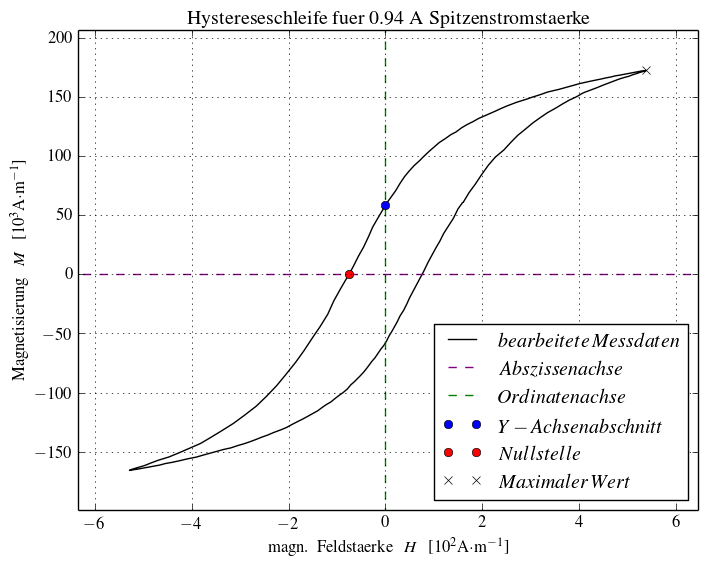


Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:
(x,y) = (0, 58.460413440720295)

Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:
(x,y) = (Any[0.0,927.577530770087])

Die negative Nullstelle (H_C) liegt bei ca.:
(x,y) = (-0.7561548189301606, 0)

Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:
(x,y) = (Any[-0.12423696762463281,0.0])

Der maximale Wert (H_max, M_S) liegt bei ca.:
(x,y) = (5.385803274229739, 172.57789138687528)

Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:
(x,y) = (Any[0.538580327422974,1666.6076749763906])


In [40]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
file = open(Kenn, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(file)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end

################################################################################################################################

#Erstelle x, und y Werte als Float64
x = []
y = []
for i in 1:length(HowMany)-1 # WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!
    push!(x, parse(Float64,DATA[i][1]))
    push!(y, parse(Float64,DATA[i][2]))
end

################################################################################################################################

# Benutze onelclockround
# x_oneclockround = []
# y_oneclockround = []
# onlyoneclockround2(x,y)

x_oneclockround = x
y_oneclockround = y

################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockround, y_oneclockround)

################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(Nullstellen[1][1] + Nullstellen[2][1])
ρ = 0.5*(Nullstellen[1][2] + Nullstellen[2][2])
Koordinatentransformation(x_oneclockround, y_oneclockround, r, ρ)

################################################################################################################################

# Wechsel von Volt zu SI-Einheiten
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschoben, y_verschoben, N, Imax, R, maximum(x_verschoben), ν, ns, q)

#Passe 10ner Potenz von den Achsen an
x_gute_Einheiten = x_gute_Einheiten*1e-2
y_gute_Einheiten = y_gute_Einheiten*1e-3

################################################################################################################################

# Erneute Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Suche Y-Achsenabschnitt und gebe aus
YAchsenabschnitte = []
YA(x_gute_Einheiten, y_gute_Einheiten)

################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_Einheiten, y_gute_Einheiten, color="black", label=L"bearbeitete \, Messdaten") #(Hystereseschleife) 

# "Plot axis" 
xa = collect(-2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten))
ya = collect(-2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, color="purple", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, color="green", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([minimum(x_gute_Einheiten)+Prozent*minimum(x_gute_Einheiten),maximum(x_gute_Einheiten)+Prozent*maximum(x_gute_Einheiten)])
ax[:set_ylim]([minimum(y_gute_Einheiten)+Prozent*minimum(y_gute_Einheiten),maximum(y_gute_Einheiten)+Prozent*maximum(y_gute_Einheiten)])

# Plotte Y-Achsenabschnitte
    plot(YAchsenabschnitte[length(YAchsenabschnitte)][1], YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label=L"Y-Achsenabschnitt" )

# Plotte Nullstellen
    plot(Nullstellen[length(Nullstellen)][1], Nullstellen[length(Nullstellen)][2], "ro", label=L"Nullstelle" )

# Plotte maximalen und minimalen Wert
plot(maximum(x_gute_Einheiten), maximum(y_gute_Einheiten), "kx", label=L"Maximaler \, Wert")

# Überschrift des PLotts
title("Hystereseschleife  fuer  0.94 A  Spitzenstromstaerke")

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

################################################################################################################################

################################################################################################################################

# Gebe Y-Achsenabschnitte aus
println()
println("Der positive Y-Achsenabschnitt (M_R) liegt bei ca.:")
for i in 2:length(YAchsenabschnitte)
    println("(x,y) = ", "(", 0, ", ",YAchsenabschnitte[i][2], ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel,0)
push!(M_H_tupel, YAchsenabschnitte[2][2])
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der positive Y-AchsenabschnittsFEHLER (DELTA M_R) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")

################################################################################################################################

# Gebe Nullstellen aus
println()
println("Die negative Nullstelle (H_C) liegt bei ca.:")
for i in 2:length(Nullstellen)
    println("(x,y) = ", "(", Nullstellen[i][1], ", ", 0, ")")
end

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, Nullstellen[2][1])
push!(M_H_tupel, 0)
OurErrors(M_H_tupel, maximum(x_verschoben), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Der negative NullstellenFEHLER (DELTA H_C) liegt bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")


################################################################################################################################

# Gebe Extremale Werte aus:
println()
println("Der maximale Wert (H_max, M_S) liegt bei ca.:")
println("(x,y) = ", "(", maximum(x_gute_Einheiten), ", ", maximum(y_gute_Einheiten), ")")

# Berechne Fehler
M_H_tupel = []
push!(M_H_tupel, maximum(x_gute_Einheiten))
push!(M_H_tupel, maximum(y_gute_Einheiten))
OurErrors(M_H_tupel, maximum(x_gute_Einheiten), ν, ns, N, R, q)

# Gebe Y-AchsenabschnitteFEHLER aus
println()
println("Die FEHLER von (DELTA (H_max, M_S)) liegen bei ca.:")
println("(x,y) = ", "(", M_H_tupel , ")")

#########################################################
WiderstandAUFGABEDAVOR = maximum(x_gute_Einheiten)/Imax
#########################################################


################################################################################################################################
################################################################################################################################
################################################################################################################################
close(file)
################################################################################################################################
################################################################################################################################
################################################################################################################################

# Teil 3.4.2

# Input

In [41]:
# txtDateien zum auslesen
measurmentA = "342a.txt"
measurmentB = "342b.txt"
measurmentC = "342c.txt"
measurmentD = "342d.txt"
measurmentE = "342e.txt"
measurmentF = "342f.txt"
measurmentG = "342g.txt"

# bzgl. Achsenbeschriftung (D.h.: Welche Einheiten sind aufgetragen?)
XLABEL = L"magn.\, Feldstaerke \, $H$ \, [$10^2$A$\cdot$m$^{-1}$]"
YLABEL = L"Magnetisierung \, $M$ \, [$10^3$A$\cdot$m$^{-1}$]"

#bzgl Titel des Plots
TITEL = "Hysteresekurven bei unterschiedlichen Spaltbreiten"

#bzgl Titel des Plots mit nur positiven y-Werten
TITELnuroben = "Magnetisierungskurven unterschiedlicher Scherung fuer einen Ringkern mit Spalt"

#bzgl. Beschriftungen der Kurven in der Legende
BeschriftungA = L"Ohne \, Spalt"
BeschriftungB = L"0.075 \, Milimeter \, Spaltbreite"
BeschriftungC = L"0.125 \, Milimeter \, Spaltbreite"
BeschriftungD = L"0.2 \, Milimeter \, Spaltbreite"
BeschriftungE = L"0.325 \, Milimeter \, Spaltbreite"
BeschriftungF = L"0.5 \, Milimeter \, Spaltbreite"
BeschriftungG = L"1 \, Milimeter \, Spaltbreite"

# bzgl. Formel (2.5) aus der Anleitung: M(f) = <U_M>/(47*4*?*ns*q*µo)
ν = 50
ns = 17 # anzahl windungen sekundärspule
q = 0.9*0.01^2

# bzgl. Formel H(f) = ((N*Imax)/(2*p*r*Umax))*U_H
N = 54 # anzahl windungen primärspule
Imax = 0.94
R = 1.5*1e-2 #radius ferritkern

#########################################################
# Widerstand der aufgabe davor
Widerstand = WiderstandAUFGABEDAVOR
#########################################################

5.729577951308233

# Output

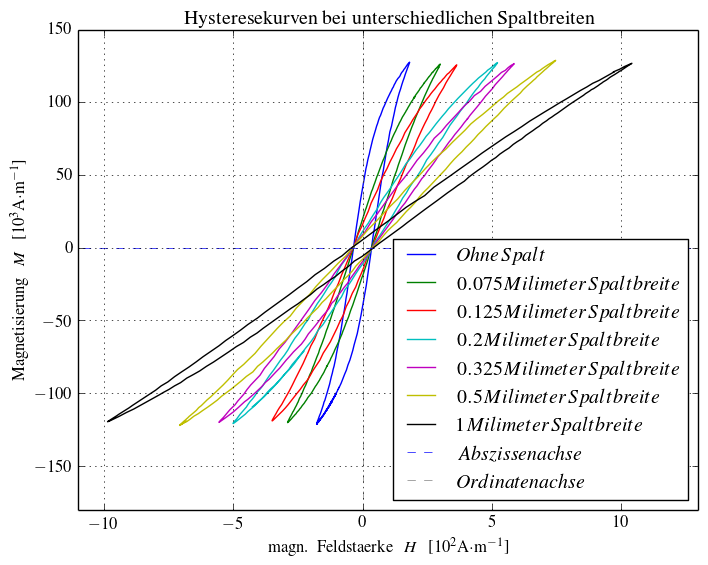

In [42]:
################################################################################################################################
################################################################################################################################
################################################################################################################################
fileA = open(measurmentA, "r")
fileB = open(measurmentB, "r")
fileC = open(measurmentC, "r")
fileD = open(measurmentD, "r")
fileE = open(measurmentE, "r")
fileF = open(measurmentF, "r")
fileG = open(measurmentG, "r")
################################################################################################################################
################################################################################################################################
################################################################################################################################

#Lese Datenpaare aus
DATA = []
HowMany =[]
for line in eachline(fileA)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end
DATAA = DATA
HowManyA = HowMany

DATA = []
HowMany =[]
for line in eachline(fileB)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end
DATAB = DATA
HowManyB = HowMany

DATA = []
HowMany =[]
for line in eachline(fileC)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end
DATAC = DATA
HowManyC = HowMany

DATA = []
HowMany =[]
for line in eachline(fileD)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end
DATAD = DATA
HowManyD = HowMany

DATA = []
HowMany =[]
for line in eachline(fileE)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end
DATAE = DATA
HowManyE = HowMany

DATA = []
HowMany =[]
for line in eachline(fileF)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end
DATAF = DATA
HowManyF = HowMany

DATA = []
HowMany =[]
for line in eachline(fileG)
    data = split(line, "\t")
    push!(DATA,data)
    push!(HowMany, 1)
end
DATAG = DATA
HowManyG = HowMany

################################################################################################################################

#Erstelle x, und y Werte als Float64 (# WHY DO I HAVE TO REST 1?? I DONT SEE WHY I HAVE TO?!?!?!)
x = []
y = []
for i in 1:length(HowManyA)-1 
    push!(x, parse(Float64,DATAA[i][1]))
    push!(y, parse(Float64,DATAA[i][2]))
end
xA = x
yA = y

x = []
y = []
for i in 1:length(HowManyB)-1 
    push!(x, parse(Float64,DATAB[i][1]))
    push!(y, parse(Float64,DATAB[i][2]))
end
xB = x
yB = y

x = []
y = []
for i in 1:length(HowManyC)-1 
    push!(x, parse(Float64,DATAC[i][1]))
    push!(y, parse(Float64,DATAC[i][2]))
end
xC = x
yC = y

x = []
y = []
for i in 1:length(HowManyD)-1 
    push!(x, parse(Float64,DATAD[i][1]))
    push!(y, parse(Float64,DATAD[i][2]))
end
xD = x
yD = y

x = []
y = []
for i in 1:length(HowManyE)-1 
    push!(x, parse(Float64,DATAE[i][1]))
    push!(y, parse(Float64,DATAE[i][2]))
end
xE = x
yE = y

x = []
y = []
for i in 1:length(HowManyF)-1 
    push!(x, parse(Float64,DATAF[i][1]))
    push!(y, parse(Float64,DATAF[i][2]))
end
xF = x
yF = y

x = []
y = []
for i in 1:length(HowManyG)-1 
    push!(x, parse(Float64,DATAG[i][1]))
    push!(y, parse(Float64,DATAG[i][2]))
end
xG = x
yG = y

################################################################################################################################

# Benutze NICHT onelclockround da messwerte gut genug und wieder boundary FEHLER auftreten --> keine Zeit mehr diese zu beheben
x_oneclockroundA = xA
y_oneclockroundA = yA

x_oneclockroundB = xB
y_oneclockroundB = yB
#schließe den Kreis...
push!(x_oneclockroundB, xB[1] )
push!(y_oneclockroundB, yB[1] )

x_oneclockroundC = xC
y_oneclockroundC = yC

x_oneclockroundD = xD
y_oneclockroundD = yD

x_oneclockroundE = xE
y_oneclockroundE = yE
#schließe den Kreis...
push!(x_oneclockroundE, xE[1] )
push!(y_oneclockroundE, yE[1] )

x_oneclockroundF = xF
y_oneclockroundF = yF

x_oneclockroundG = xG
y_oneclockroundG = yG

################################################################################################################################

#Nullstellensuche und Ausgabe
Nullstellen = []
Nullstellensuche2(x_oneclockroundA, y_oneclockroundA)
NullstellenA = Nullstellen

Nullstellen = []
Nullstellensuche2(x_oneclockroundB, y_oneclockroundB)
NullstellenB = Nullstellen

Nullstellen = []
Nullstellensuche2(x_oneclockroundC, y_oneclockroundC)
NullstellenC = Nullstellen

Nullstellen = []
Nullstellensuche2(x_oneclockroundD, y_oneclockroundD)
NullstellenD = Nullstellen

Nullstellen = []
Nullstellensuche2(x_oneclockroundE, y_oneclockroundE)
NullstellenE = Nullstellen

Nullstellen = []
Nullstellensuche2(x_oneclockroundF, y_oneclockroundF)
NullstellenF = Nullstellen

Nullstellen = []
Nullstellensuche2(x_oneclockroundG, y_oneclockroundG)
NullstellenG = Nullstellen

################################################################################################################################

#Behebe systematischer Fehlverschiebung des Graphen aka. zentriere Messwerte um Null herum.
x_verschoben = []
y_verschoben = []
r = 0.5*(NullstellenA[1][1] + NullstellenA[2][1])
ρ = 0.5*(NullstellenA[1][2] + NullstellenA[2][2])
Koordinatentransformation(x_oneclockroundA, y_oneclockroundA, r, ρ)
x_verschobenA = x_verschoben
y_verschobenA = y_verschoben

x_verschoben = []
y_verschoben = []
r = 0.5*(NullstellenB[1][1] + NullstellenB[2][1])
ρ = 0.5*(NullstellenB[1][2] + NullstellenB[2][2])
Koordinatentransformation(x_oneclockroundB, y_oneclockroundB, r, ρ)
x_verschobenB = x_verschoben
y_verschobenB = y_verschoben

x_verschoben = []
y_verschoben = []
r = 0.5*(NullstellenC[1][1] + NullstellenC[2][1])
ρ = 0.5*(NullstellenC[1][2] + NullstellenC[2][2])
Koordinatentransformation(x_oneclockroundC, y_oneclockroundC, r, ρ)
x_verschobenC = x_verschoben
y_verschobenC = y_verschoben

x_verschoben = []
y_verschoben = []
r = 0.5*(NullstellenD[1][1] + NullstellenD[2][1])
ρ = 0.5*(NullstellenD[1][2] + NullstellenD[2][2])
Koordinatentransformation(x_oneclockroundD, y_oneclockroundD, r, ρ)
x_verschobenD = x_verschoben
y_verschobenD= y_verschoben

x_verschoben = []
y_verschoben = []
r = 0.5*(NullstellenE[1][1] + NullstellenE[2][1])
ρ = 0.5*(NullstellenE[1][2] + NullstellenE[2][2])
Koordinatentransformation(x_oneclockroundE, y_oneclockroundE, r, ρ)
x_verschobenE = x_verschoben
y_verschobenE = y_verschoben

x_verschoben = []
y_verschoben = []
r = 0.5*(NullstellenF[1][1] + NullstellenF[2][1])
ρ = 0.5*(NullstellenF[1][2] + NullstellenF[2][2])
Koordinatentransformation(x_oneclockroundF, y_oneclockroundF, r, ρ)
x_verschobenF = x_verschoben
y_verschobenF = y_verschoben

x_verschoben = []
y_verschoben = []
r = 0.5*(NullstellenG[1][1] + NullstellenG[2][1])
ρ = 0.5*(NullstellenG[1][2] + NullstellenG[2][2])
Koordinatentransformation(x_oneclockroundG, y_oneclockroundG, r, ρ)
x_verschobenG = x_verschoben
y_verschobenG = y_verschoben

################################################################################################################################

# Wechsel von Volt zu SI-Einheiten UND #Passe 10ner Potenz von den Achsen an
x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschobenA, y_verschobenA, N, maximum(x_verschobenA)/Widerstand, R, maximum(x_verschobenA), ν, ns, q)
x_gute_EinheitenA = x_gute_Einheiten*1e-2
y_gute_EinheitenA = y_gute_Einheiten*1e-3

x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschobenB, y_verschobenB, N, maximum(x_verschobenB)/Widerstand, R, maximum(x_verschobenB), ν, ns, q)
x_gute_EinheitenB = x_gute_Einheiten*1e-2
y_gute_EinheitenB = y_gute_Einheiten*1e-3

x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschobenC, y_verschobenC, N, maximum(x_verschobenC)/Widerstand, R, maximum(x_verschobenC), ν, ns, q)
x_gute_EinheitenC = x_gute_Einheiten*1e-2
y_gute_EinheitenC = y_gute_Einheiten*1e-3

x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschobenD, y_verschobenD, N, maximum(x_verschobenD)/Widerstand, R, maximum(x_verschobenD), ν, ns, q)
x_gute_EinheitenD = x_gute_Einheiten*1e-2
y_gute_EinheitenD = y_gute_Einheiten*1e-3

x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschobenE, y_verschobenE, N, maximum(x_verschobenE)/Widerstand, R, maximum(x_verschobenE), ν, ns, q)
x_gute_EinheitenE = x_gute_Einheiten*1e-2
y_gute_EinheitenE = y_gute_Einheiten*1e-3

x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschobenF, y_verschobenF, N, maximum(x_verschobenF)/Widerstand, R, maximum(x_verschobenF), ν, ns, q)
x_gute_EinheitenF = x_gute_Einheiten*1e-2
y_gute_EinheitenF = y_gute_Einheiten*1e-3

x_gute_Einheiten = []
y_gute_Einheiten = []
Einheiten_umrechner(x_verschobenG, y_verschobenG, N, maximum(x_verschobenG)/Widerstand, R, maximum(x_verschobenG), ν, ns, q)
x_gute_EinheitenG = x_gute_Einheiten*1e-2
y_gute_EinheitenG = y_gute_Einheiten*1e-3


################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################

# Plotte Daten
#---------------
plot(x_gute_EinheitenA, y_gute_EinheitenA, label=BeschriftungA) #(Hystereseschleife) 
plot(x_gute_EinheitenB, y_gute_EinheitenB, label=BeschriftungB) #(Hystereseschleife) 
plot(x_gute_EinheitenC, y_gute_EinheitenC, label=BeschriftungC) #(Hystereseschleife) 
plot(x_gute_EinheitenD, y_gute_EinheitenD, label=BeschriftungD) #(Hystereseschleife) 
plot(x_gute_EinheitenE, y_gute_EinheitenE, label=BeschriftungE) #(Hystereseschleife) 
plot(x_gute_EinheitenF, y_gute_EinheitenF, label=BeschriftungF) #(Hystereseschleife) 
plot(x_gute_EinheitenG, y_gute_EinheitenG, label=BeschriftungG) #(Hystereseschleife) 

###############################################################################################################################

# # Plotte Nullstellen
# plot(Nullstellen[length(Nullstellen)][1], Nullstellen[length(Nullstellen)][2], "ro", label=L"Nullstelle" )

# ###############################################################################################################################

# # Plotte maximalen und minimalen Wert
# plot(maximum(x_gute_Einheiten), maximum(y_gute_Einheiten), "kx", label=L"Maximaler \, Wert")

# ##############################################################################################################################

# Plotte Y-Achsenabschnitte
# plot(YAchsenabschnitte[length(YAchsenabschnitte)][1], YAchsenabschnitte[length(YAchsenabschnitte)][2], "bo", label=L"Y-Achsenabschnitt" )

###############################################################################################################################
###############################################################################################################################
###############################################################################################################################

# "Plot axis" 
xa = collect(-2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten))
ya = collect(-2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, linewidth=0.5, linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, linewidth=0.5, color="gray", linestyle="--", label=L"Ordinatenachse")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([-11,13])
ax[:set_ylim]([-180,150])

# Überschrift des PLotts
title(TITEL)

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="lower right")
grid()

###############################################################################################################################
###############################################################################################################################
###############################################################################################################################
################################################################################################################################
################################################################################################################################
################################################################################################################################
close(fileA)
close(fileB)
close(fileC)
close(fileD)
close(fileE)
close(fileF)
close(fileG)
################################################################################################################################
################################################################################################################################
################################################################################################################################

In [43]:
###############################################################################################################################
###############################################################################################################################
###############################################################################################################################

Hi  = maximum(x_gute_EinheitenA)
HaB = maximum(x_gute_EinheitenB)
HaC = maximum(x_gute_EinheitenC)
HaD = maximum(x_gute_EinheitenD)
HaE = maximum(x_gute_EinheitenE)
HaF = maximum(x_gute_EinheitenF)
HaG = maximum(x_gute_EinheitenG)

HentB = Hi - HaB
HentC = Hi - HaC
HentD = Hi - HaD
HentE = Hi - HaE
HentF = Hi - HaF
HentG = Hi - HaG

println("WERTE DIE WIR BESTIMMEN MÜSSEN SIND FOLGENDE:")
println()
println("H_i =  ", Hi )
println("H_a(0.075mm)=  ",HaB ,"; --> H_ent(0.075mm)=  ",HentB,"  =Ha-Hi")
println("H_a(0.125mm)=  ",HaC ,"; --> H_ent(0.125mm)=  ",HentC,"  =Ha-Hi")
println("H_a(0.2mm)=  ",HaD ,"; --> H_ent(0.25mm)=  ",HentD,"  =Ha-Hi")
println("H_a(0.325mm)=  ",HaE ,"; --> H_ent(0.325mm)=  ",HentE,"  =Ha-Hi")
println("H_a(0.5mm)=  ",HaF ,"; --> H_ent(0.5mm)=  ",HentF,"  =Ha-Hi")
println("H_a(1mm)=  ",HaG ,"; --> H_ent(1mm)=  ",HentG,"  =Ha-Hi")

N = 54 # anzahl windungen primärspule
R = 1.5*1e-2 #radius ferritkern
function Hent_Fehler(Imaxa, Imaxi, N, R, x)
    Delta_Ha = (0.001*Imaxa*N)/(2π*R)
    Delta_Hi = (0.001*Imaxi*N)/(2π*R)
    Delta_Hent = sqrt(Delta_Ha^2 + Delta_Hi^2)
    x = Delta_Hent
    println("ΔDelta_Hent=", Delta_Hent)
end
ImaxA = maximum(x_verschobenA)/Widerstand #Imaxi
ImaxB = maximum(x_verschobenB)/Widerstand #Imaxa
ImaxC = maximum(x_verschobenC)/Widerstand #Imaxa
ImaxD = maximum(x_verschobenD)/Widerstand #Imaxa
ImaxE = maximum(x_verschobenE)/Widerstand #Imaxa
ImaxF = maximum(x_verschobenF)/Widerstand #Imaxa
ImaxG = maximum(x_verschobenG)/Widerstand #Imaxa

x=1
println()
println("DIE FEHLER SIND DABEI FOLGENDE:")
println("0.075mm: ")
Hent_Fehler(ImaxB, ImaxA, N, R,x)
Delta_HentB = x
println("0.125mm: ")
Hent_Fehler(ImaxC, ImaxA, N, R,x)
Delta_HentC = x
println("0.2mm: ")
Hent_Fehler(ImaxD, ImaxA, N, R,x)
Delta_HentD = x
println("0.325mm: ")
Hent_Fehler(ImaxE, ImaxA, N, R,x)
Delta_HentE= x
println("0.5mm: ")
Hent_Fehler(ImaxF, ImaxA, N, R,x)
Delta_HentF = x
println("1mm: ")
Hent_Fehler(ImaxG, ImaxA, N, R,x)
Delta_HentG = x

###############################################################################################################################
################################################################################################################################
###############################################################################################################################

WERTE DIE WIR BESTIMMEN MÜSSEN SIND FOLGENDE:

H_i =  1.821768196382082
H_a(0.075mm)=  3.006292820555823; --> H_ent(0.075mm)=  -1.184524624173741  =Ha-Hi
H_a(0.125mm)=  3.648160543390184; --> H_ent(0.125mm)=  -1.8263923470081018  =Ha-Hi
H_a(0.2mm)=  5.2237502368495905; --> H_ent(0.25mm)=  -3.4019820404675087  =Ha-Hi
H_a(0.325mm)=  5.86581379942129; --> H_ent(0.325mm)=  -4.0440456030392085  =Ha-Hi
H_a(0.5mm)=  7.475233013354449; --> H_ent(0.5mm)=  -5.653464816972368  =Ha-Hi
H_a(1mm)=  10.425423721687997; --> H_ent(1mm)=  -8.603655525305914  =Ha-Hi

DIE FEHLER SIND DABEI FOLGENDE:
0.075mm: 
ΔDelta_Hent=0.3515200689046745
0.125mm: 
ΔDelta_Hent=0.40777340167914566
0.2mm: 
ΔDelta_Hent=0.5532305658433506
0.325mm: 
ΔDelta_Hent=0.614219919009718
0.5mm: 
ΔDelta_Hent=0.7694020273257244
1mm: 
ΔDelta_Hent=1.0583397334414126


1

# nur positive y Werte...

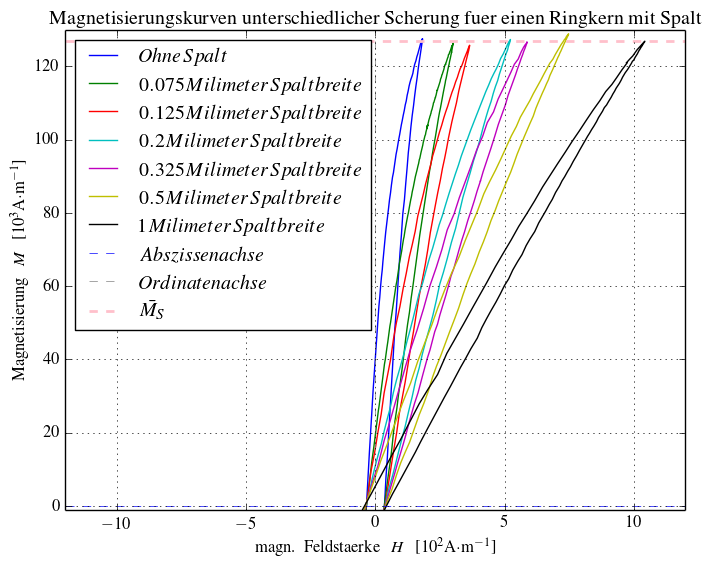

MI=127.01826217824272
Delta_MI=0.9984921682582449
Any[127.01826217824272,127.01826217824272,127.01826217824272]


In [44]:
# Plotte Daten
#---------------
plot(x_gute_EinheitenA, y_gute_EinheitenA, label=BeschriftungA) #(Hystereseschleife) 
plot(x_gute_EinheitenB, y_gute_EinheitenB, label=BeschriftungB) #(Hystereseschleife) 
plot(x_gute_EinheitenC, y_gute_EinheitenC, label=BeschriftungC) #(Hystereseschleife) 
plot(x_gute_EinheitenD, y_gute_EinheitenD, label=BeschriftungD) #(Hystereseschleife) 
plot(x_gute_EinheitenE, y_gute_EinheitenE, label=BeschriftungE) #(Hystereseschleife) 
plot(x_gute_EinheitenF, y_gute_EinheitenF, label=BeschriftungF) #(Hystereseschleife) 
plot(x_gute_EinheitenG, y_gute_EinheitenG, label=BeschriftungG) #(Hystereseschleife)

###############################################################################################################################
###############################################################################################################################
###############################################################################################################################

#bestimme mittlere sättigungsmagnetisierung
MSA=maximum(y_gute_EinheitenA)
MSB=maximum(y_gute_EinheitenB)
MSC=maximum(y_gute_EinheitenC)
MSD=maximum(y_gute_EinheitenD)
MSE=maximum(y_gute_EinheitenE)
MSF=maximum(y_gute_EinheitenF)
MSG=maximum(y_gute_EinheitenG)

MI=(1/7)*(MSA+ MSB+ MSC+ MSD+ MSE+ MSF+ MSG)
Delta_MI = sqrt((1/6)*((MSA-MI)^2+ (MSB-MI)^2+ (MSC-MI)^2+ (MSD-MI)^2+ (MSE-MI)^2+(MSF-MI)^2+ (MSG-MI)^2))

#gebe ergebnisse aus
println("MI=",MI)
println("Delta_MI=",Delta_MI)

###############################################################################################################################
###############################################################################################################################
###############################################################################################################################

# "Plot axis" 
xa = collect(-2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten))
ya = collect(-2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, linewidth=0.5, linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, linewidth=0.5, color="gray", linestyle="--", label=L"Ordinatenachse")

# Plotte mittlere magnetisierung
XA = []
for i in 1:length(xa)
    push!(XA,MI)
end
println(XA)
plot(xa, XA, linewidth=2.0,color="pink", linestyle="--", label=L"$\bar{M_S}$")

# get the current axis argument of the plot
# Setze x- und y-Range fest
ax = gca()
ax[:set_xlim]([-12,12])
ax[:set_ylim]([-1,130])

# Überschrift des PLotts
title(TITELnuroben)

# Bennene Achsen
xlabel(XLABEL)
ylabel(YLABEL)
legend(loc="upper left")
grid()
###############################################################################################################################
###############################################################################################################################
###############################################################################################################################

In [45]:
##############################################################################################################################
###############################################################################################################################
###############################################################################################################################

#BERECHNE Nmess
NB = - HentB/MI
NC = - HentC/MI
ND = - HentD/MI
NE = - HentE/MI
NF = - HentF/MI
NG = - HentG/MI

#BERCHNE FEHLER DAVON
ΔNB = sqrt((Delta_MI*HentB/MI^2)^2+(Delta_HentB/MI)^2)
ΔNC = sqrt((Delta_MI*HentC/MI^2)^2+(Delta_HentC/MI)^2)
ΔND = sqrt((Delta_MI*HentD/MI^2)^2+(Delta_HentD/MI)^2)
ΔNE = sqrt((Delta_MI*HentE/MI^2)^2+(Delta_HentE/MI)^2)
ΔNF = sqrt((Delta_MI*HentF/MI^2)^2+(Delta_HentF/MI)^2)
ΔNG = sqrt((Delta_MI*HentG/MI^2)^2+(Delta_HentG/MI)^2)

#berechne theoretischen fehler
R = 1.5*1e-2 #radius ferritkern
LAB = 0.075*1e-3
LAC = 0.125*1e-3
LAD = 0.2*1e-3
LAE = 0.325*1e-3
LAF = 0.5*1e-3
LAG = 1*1e-3
Lring = 2π*R
println("Lring",Lring)

NtB = LAB/(LAB +Lring)
NtC = LAC/(LAC +Lring)
NtD = LAD/(LAD +Lring)
NtE = LAE/(LAE +Lring)
NtF = LAF/(LAF +Lring)
NtG = LAG/(LAG +Lring)

#gebe daten aus
println()
println("DAMIT ERGIBT SICH FÜR DIE ENTMAGNETISIERUNGSFAKTOREN:")
println("N(0.075mm) =  ", NB , "   Δ= ", ΔNB)
println("N(0.125mm) =  ", NC , "  Δ= ", ΔNC)
println("N(0.2mm) =  ", ND , "  Δ= ", ΔND)
println("N(0.325mm) =  ", NE  , "  Δ= ", ΔNE)
println("N(0.5mm) =  ", NF  , "  Δ= ", ΔNF)
println("N(1mm) =  ", NG  , "  Δ= ", ΔNG)

println()
println("DIE THEORETISCHEN ENTMAGNETISIERUNGSFAKTOREN SIND:")
println("Nt(0.075mm) =  ", NtB)
println("Nt(0.125mm) =  ", NtC)
println("Nt(0.2mm) =  ", NtD)
println("Nt(0.325mm) =  ", NtE)
println("Nt(0.5mm) =  ", NtF)
println("Nt(1mm) =  ", NtG)
###############################################################################################################################
###############################################################################################################################

Lring0.09424777960769379

DAMIT ERGIBT SICH FÜR DIE ENTMAGNETISIERUNGSFAKTOREN:
N(0.075mm) =  0.009325624550834402   Δ= 0.007873224956112614
N(0.125mm) =  0.014378974453651038  Δ= 0.007873695037823918
N(0.2mm) =  0.026783408795922285  Δ= 0.007875698451505668
N(0.325mm) =  0.03183830052220572  Δ= 0.0078768609066478
N(0.5mm) =  0.04450907074322076  Δ= 0.007880654636062526
N(1mm) =  0.06773557894558926  Δ= 0.00789086950739291

DIE THEORETISCHEN ENTMAGNETISIERUNGSFAKTOREN SIND:
Nt(0.075mm) =  0.0007951419615912415
Nt(0.125mm) =  0.0013245344740254882
Nt(0.2mm) =  0.002117572279949161
Nt(0.325mm) =  0.003436506797708209
Nt(0.5mm) =  0.005277168521207209
Nt(1mm) =  0.010498932406810914


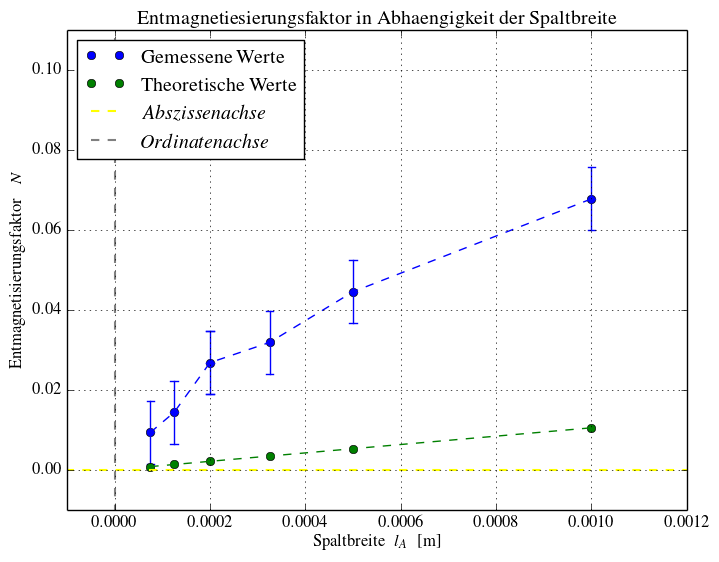

In [46]:
L = []
push!(L,LAB)
push!(L,LAC)
push!(L,LAD)
push!(L,LAE)
push!(L,LAF)
push!(L,LAG)

N = []
push!(N,NB)
push!(N,NC)
push!(N,ND)
push!(N,NE)
push!(N,NF)
push!(N,NG)

Nt = []
push!(Nt,NtB)
push!(Nt,NtC)
push!(Nt,NtD)
push!(Nt,NtE)
push!(Nt,NtF)
push!(Nt,NtG)

plot(LAB,NB, "bo")
plot(LAC,NC, "bo")
plot(LAD,ND, "bo")
plot(LAE,NE, "bo")
plot(LAF,NF, "bo")
plot(LAG,NG, "bo", label="Gemessene Werte")
plot(L,N,linestyle="--", color="blue")

ICHSb = []
for i in 1:3
    push!(ICHSb, LAB)
end
nb = []
push!(nb, NB- ΔNB)
push!(nb, NB)
push!(nb, NB+ ΔNB)

ICHSc = []
for i in 1:3
    push!(ICHSc, LAC)
end
nc = []
push!(nc, NC- ΔNC)
push!(nc, NC)
push!(nc, NC+ ΔNC)

ICHSd = []
for i in 1:3
    push!(ICHSd, LAD)
end
nd = []
push!(nd, ND- ΔND)
push!(nd, ND)
push!(nd, ND+ ΔND)

ICHSe = []
for i in 1:3
    push!(ICHSe, LAE)
end
ne = []
push!(ne, NE- ΔNE)
push!(ne, NE)
push!(ne, NE+ ΔNE)

ICHSf = []
for i in 1:3
    push!(ICHSf, LAF)
end
nf = []
push!(nf, NF- ΔNF)
push!(nf, NF)
push!(nf, NF+ ΔNF)

ICHSg = []
for i in 1:3
    push!(ICHSg, LAG)
end
ng = []
push!(ng, NG- ΔNG)
push!(ng, NG)
push!(ng, NG+ ΔNG)

plot(ICHSb, nb, color="blue")
plot(ICHSc, nc, color="blue")
plot(ICHSd, nd, color="blue")
plot(ICHSe, ne, color="blue")
plot(ICHSf, nf, color="blue")
plot(ICHSg, ng, color="blue")

K = 0.000008 # Balkungskante

Loben = []
push!(Loben,LAB-K)
push!(Loben,LAB)
push!(Loben,LAB+K)
Noben = []
push!(Noben,nb)
push!(Noben,nb)
push!(Noben,nb)
plot(Loben, Noben, color="blue")

Loben = []
push!(Loben,LAC-K)
push!(Loben,LAC)
push!(Loben,LAC+K)
Noben = []
push!(Noben,nc)
push!(Noben,nc)
push!(Noben,nc)
plot(Loben, Noben, color="blue")

Loben = []
push!(Loben,LAD-K)
push!(Loben,LAD)
push!(Loben,LAD+K)
Noben = []
push!(Noben,nd)
push!(Noben,nd)
push!(Noben,nd)
plot(Loben, Noben, color="blue")

Loben = []
push!(Loben,LAD-K)
push!(Loben,LAD)
push!(Loben,LAD+K)
Noben = []
push!(Noben,nd)
push!(Noben,nd)
push!(Noben,nd)
plot(Loben, Noben, color="blue")

Loben = []
push!(Loben,LAE-K)
push!(Loben,LAE)
push!(Loben,LAE+K)
Noben = []
push!(Noben,ne)
push!(Noben,ne)
push!(Noben,ne)
plot(Loben, Noben, color="blue")

Loben = []
push!(Loben,LAF-K)
push!(Loben,LAF)
push!(Loben,LAF+K)
Noben = []
push!(Noben,nf)
push!(Noben,nf)
push!(Noben,nf)
plot(Loben, Noben, color="blue")

Loben = []
push!(Loben,LAG-K)
push!(Loben,LAG)
push!(Loben,LAG+K)
Noben = []
push!(Noben,ng)
push!(Noben,ng)
push!(Noben,ng)
plot(Loben, Noben, color="blue")

plot(LAB,NtB, "go")
plot(LAC,NtC, "go")
plot(LAD,NtD, "go")
plot(LAE,NtE, "go")
plot(LAF,NtF, "go")
plot(LAG,NtG, "go", label="Theoretische Werte")
plot(L,Nt,linestyle="--", color="green")

################################################################################################################################

xa = collect(-2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten):2*maximum(x_gute_Einheiten))
ya = collect(-2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten):2*maximum(y_gute_Einheiten))
plot(xa, 0*xa, linewidth=1.5, color="yellow", linestyle="--", label=L"Abszissenachse")
plot(0*ya, ya, linewidth=1.5, color="gray", linestyle="--", label=L"Ordinatenachse")

ax = gca()
ax[:set_xlim]([-0.0001,0.0012])
ax[:set_ylim]([-0.01,0.11])

title("Entmagnetiesierungsfaktor in Abhaengigkeit der Spaltbreite")

xlabel(L"Spaltbreite\,\, $l_A$ \,\,[m]")
ylabel(L"Entmagnetisierungsfaktor \,\, $N$")
legend(loc="upper left")
grid()